In [1]:
import json
from pathlib import Path

import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
from google.colab import drive
drive.mount("/content/drive")
BASE_DIR = "/content/drive/MyDrive/data/maestro-patch64-block10-42"

configs = {
    # data
    "batch_size": 8,

    # model
    "base_channels": 64,
    "dropout": 0.2,

    # training
    "epochs": 60,
    "patience": 10,
    "base_lr": 1e-4,
    "max_lr": 3e-4,
    "weight_decay": 1e-4,
    "scheduler": "CosineAnnealingLR",  # or None

    # multi-task loss weights
    "seg_weight": 1.0,
    "height_weight": 1.0,
    "biomass_weight": 1.0,
}


IGNORE_INDEX = -1  # for segmentation ignore_index
S1_MIN_THRESHOLD = 999  # dB clipping for Sentinel-1 backscatter
S1_MAX_THRESHOLD = -999

RARE_GENUS_NAMES = {
    "betula",
    "castanea",
    "corylus",
    "robinia",
    "sorbus",
    "salix",
    "prunus",
    "larix",
    "populus",
    "malus",
    "ulmus",
    "crataegus",

    "tilia",
    "acer",
    "alnus",
    "carpinus"
}

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loader Data

### Data Related Functions

In [2]:
def compute_ignored_seg_class_indices(code_to_index: dict[int, int]) -> list[int]:
    """Compute segmentation class indices to ignore based on rare genus names.

    We map genus names -> original genus codes via genus_map.json, then to
    contiguous class indices via ``code_to_index``.
    """

    ignored: set[int] = set()

    # Locate genus_map.json relative to this file (project root / "@data/auxiliary")
    try:
        genus_map_path = BASE_DIR+"/genus_map.json"
        with open(genus_map_path, "r", encoding="utf-8") as f:
            genus_to_code = json.load(f)
    except FileNotFoundError:
        print("[Warning] genus_map.json not found; no segmentation classes will be ignored.")
        return []

    # Normalize keys to lower-case for robust matching
    genus_to_code_lc = {k.lower(): int(v) for k, v in genus_to_code.items()}

    for g in RARE_GENUS_NAMES:
        code = genus_to_code_lc.get(g.lower())
        if code is None:
            print(f"[Warning] Genus '{g}' not found in genus_map; skipping.")
            continue
        if code not in code_to_index:
            # This genus might not appear in the current patches
            continue
        ignored.add(code_to_index[code])

    ignored_list = sorted(ignored)
    if ignored_list:
        print("Segmentation classes to ignore (indices):", ignored_list)
    else:
        print("No segmentation classes will be ignored (rare genus not present in patches).")

    return ignored_list

def load_all_patches(base_dir: str):
    base_path = Path(base_dir)
    patches_train = np.load(base_path / "patches_train.npy")  # (N, 5, 64, 64)
    patches_val = np.load(base_path / "patches_val.npy")
    patches_test = np.load(base_path / "patches_test.npy")

    # Channel order in patches_: 0: VH, 1: VV, 2: biomass, 3: genus, 4: height
    genus_train = patches_train[:, 3, ...]
    genus_val = patches_val[:, 3, ...]
    genus_test = patches_test[:, 3, ...]

    all_genus = np.concatenate(
        [genus_train.reshape(-1), genus_val.reshape(-1), genus_test.reshape(-1)]
    )
    mask = np.isfinite(all_genus) & (all_genus > 0)
    codes = np.unique(all_genus[mask].astype(int))
    codes_sorted = sorted(int(c) for c in codes)
    code_to_index = {code: idx for idx, code in enumerate(codes_sorted)}
    index_to_code = {idx: code for code, idx in code_to_index.items()}

    print("Genus codes used in dataset (code -> index):")
    print(code_to_index)

    return (
        patches_train,
        patches_val,
        patches_test,
        code_to_index,
        index_to_code,
    )


class IMAESTROSegDataset(Dataset):
    """Dataset for multi-task learning on 64x64 patches.

    Inputs:
        - x: Sentinel-1 VH/VV (2 channels), clipped to [S1_MIN_THRESHOLD, S1_MAX_THRESHOLD].
    Targets:
        - y_seg: genus segmentation, shape (H, W), with labels in [0, num_classes-1]
                 and IGNORE_INDEX for invalid pixels.
        - y_height: height95 map, shape (1, H, W), NaN for invalid pixels.
        - y_biomass: biomass_t_ha map, shape (1, H, W), NaN for invalid pixels.
    """

    def __init__(
        self,
        patches: np.ndarray,
        code_to_index: dict[int, int],
        ignore_index: int = IGNORE_INDEX,
        ignore_class_indices: list[int] | None = None,
    ) -> None:
        super().__init__()

        if patches.ndim != 4:
            raise ValueError(f"Expected patches of shape (N, C, H, W), got {patches.shape}")

        vh = patches[:, 0, ...].astype(np.float32)
        vv = patches[:, 1, ...].astype(np.float32)
        s1 = np.stack([vh, vv], axis=1)

        biomass = patches[:, 2, ...].astype(np.float32)
        genus_raw = patches[:, 3, ...].astype(np.float32)
        height = patches[:, 4, ...].astype(np.float32)

        # Handle NaN / NoData for regression targets
        def _clean_reg_target(arr: np.ndarray) -> np.ndarray:
            out = arr.copy()
            # Treat very negative values (e.g., -9999) as invalid
            mask_invalid = ~np.isfinite(out) | (out < -1e3)
            out[mask_invalid] = np.nan
            return out

        biomass = _clean_reg_target(biomass)
        height = _clean_reg_target(height)

        # Genus segmentation: map codes -> contiguous indices, others -> IGNORE_INDEX
        genus = np.full_like(genus_raw, ignore_index, dtype=np.int64)
        valid_mask = np.isfinite(genus_raw) & (genus_raw > 0)
        genus_int = genus_raw[valid_mask].astype(int)

        # Vectorized mapping from code to index
        if len(code_to_index) > 0:
            mapped = np.vectorize(lambda c: code_to_index.get(int(c), ignore_index))(
                genus_int
            )
            genus[valid_mask] = mapped
        # Further ignore specified rare classes by mapping them to IGNORE_INDEX
        if ignore_class_indices is not None and len(ignore_class_indices) > 0:
            ignore_arr = np.array(ignore_class_indices, dtype=np.int64)
            mask_rare = np.isin(genus, ignore_arr)
            if mask_rare.any():
                genus[mask_rare] = ignore_index

        self.inputs = torch.from_numpy(s1)  # (N, 2, H, W)
        self.seg_targets = torch.from_numpy(genus.astype(np.int64))  # (N, H, W)
        self.height_targets = torch.from_numpy(height).unsqueeze(1)  # (N, 1, H, W)
        self.biomass_targets = torch.from_numpy(biomass).unsqueeze(1)  # ditto

    def __len__(self) -> int:  # type: ignore[override]
        return self.inputs.shape[0]

    def __getitem__(self, idx: int):  # type: ignore[override]
        x = self.inputs[idx]
        y_seg = self.seg_targets[idx]
        y_h = self.height_targets[idx]
        y_b = self.biomass_targets[idx]
        return x, y_seg, y_h, y_b


def make_datasets(base_dir: str):
    (
        patches_train,
        patches_val,
        patches_test,
        code_to_index,
        index_to_code,
    ) = load_all_patches(base_dir)

    ignored_seg_class_indices = compute_ignored_seg_class_indices(code_to_index)

    train_ds = IMAESTROSegDataset(
        patches_train,
        code_to_index,
        IGNORE_INDEX,
        ignore_class_indices=ignored_seg_class_indices,
    )
    val_ds = IMAESTROSegDataset(
        patches_val,
        code_to_index,
        IGNORE_INDEX,
        ignore_class_indices=ignored_seg_class_indices,
    )
    test_ds = IMAESTROSegDataset(
        patches_test,
        code_to_index,
        IGNORE_INDEX,
        ignore_class_indices=ignored_seg_class_indices,
    )

    print("Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))
    num_classes = len(code_to_index)
    return (
        train_ds,
        val_ds,
        test_ds,
        num_classes,
        code_to_index,
        index_to_code,
        ignored_seg_class_indices,
    )

def visualize_dataset_triplet_sample(
    train_ds: IMAESTROSegDataset,
    val_ds: IMAESTROSegDataset,
    test_ds: IMAESTROSegDataset,
    idx_train: int = 0,
    idx_val: int = 0,
    idx_test: int = 0,
    num_classes: int = 0,
) -> None:
    """Visualize one sample from train/val/test datasets.

    Each row corresponds to a split (Train / Val / Test) and shows:
        VV, VH, genus segmentation (index), height, biomass.
    """

    samples = [
        ("Train", train_ds, int(idx_train)),
        ("Val", val_ds, int(idx_val)),
        ("Test", test_ds, int(idx_test)),
    ]

    n = len(samples)

    fig, axes = plt.subplots(nrows=n, ncols=5, figsize=(3 * 5, 2.5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for row, (split_name, ds, idx) in enumerate(samples):
        ax_row = axes[row]
        x, y_seg, y_h, y_b = ds[idx]

        x_np = x.cpu().numpy()
        y_seg_np = y_seg.cpu().numpy()
        y_h_np = y_h.cpu().numpy()[0]
        y_b_np = y_b.cpu().numpy()[0]

        vv = x_np[1, :, :]
        vh = x_np[0, :, :]
        seg = y_seg_np.copy()

        mask_invalid = ~np.isfinite(seg) | (seg == IGNORE_INDEX)
        seg = np.ma.array(seg, mask=mask_invalid)

        images = [vv, vh, seg, y_h_np, y_b_np]
        titles = ["VV", "VH", "Genus index", "Height", "Biomass"]

        for col in range(5):
            ax = ax_row[col]
            band = images[col]

            if col in (0, 1):
                cmap = "cividis"
                im = ax.imshow(band, cmap=cmap)
            elif col == 2:
                cmap = "tab20"
                im = ax.imshow(
                    band,
                    cmap=cmap,
                    vmin=0,
                    vmax=max(num_classes - 1, 1),
                )
            else:
                cmap = "viridis"
                im = ax.imshow(band, cmap=cmap)

            if row == 0:
                ax.set_title(titles[col])
            if col == 0:
                ax.set_ylabel(split_name)
            ax.axis("off")

            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
            cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    plt.show()

### Load all data

Genus codes used in dataset (code -> index):
{1: 0, 2: 1, 4: 2, 5: 3, 7: 4, 8: 5, 9: 6, 10: 7, 11: 8, 13: 9, 16: 10, 17: 11, 19: 12, 20: 13, 21: 14, 22: 15, 25: 16, 26: 17, 27: 18, 28: 19, 30: 20, 31: 21}
Segmentation classes to ignore (indices): [1, 2, 3, 4, 5, 6, 7, 10, 11, 14, 15, 17, 18, 19, 20, 21]
Train: 724 Val: 145 Test: 109


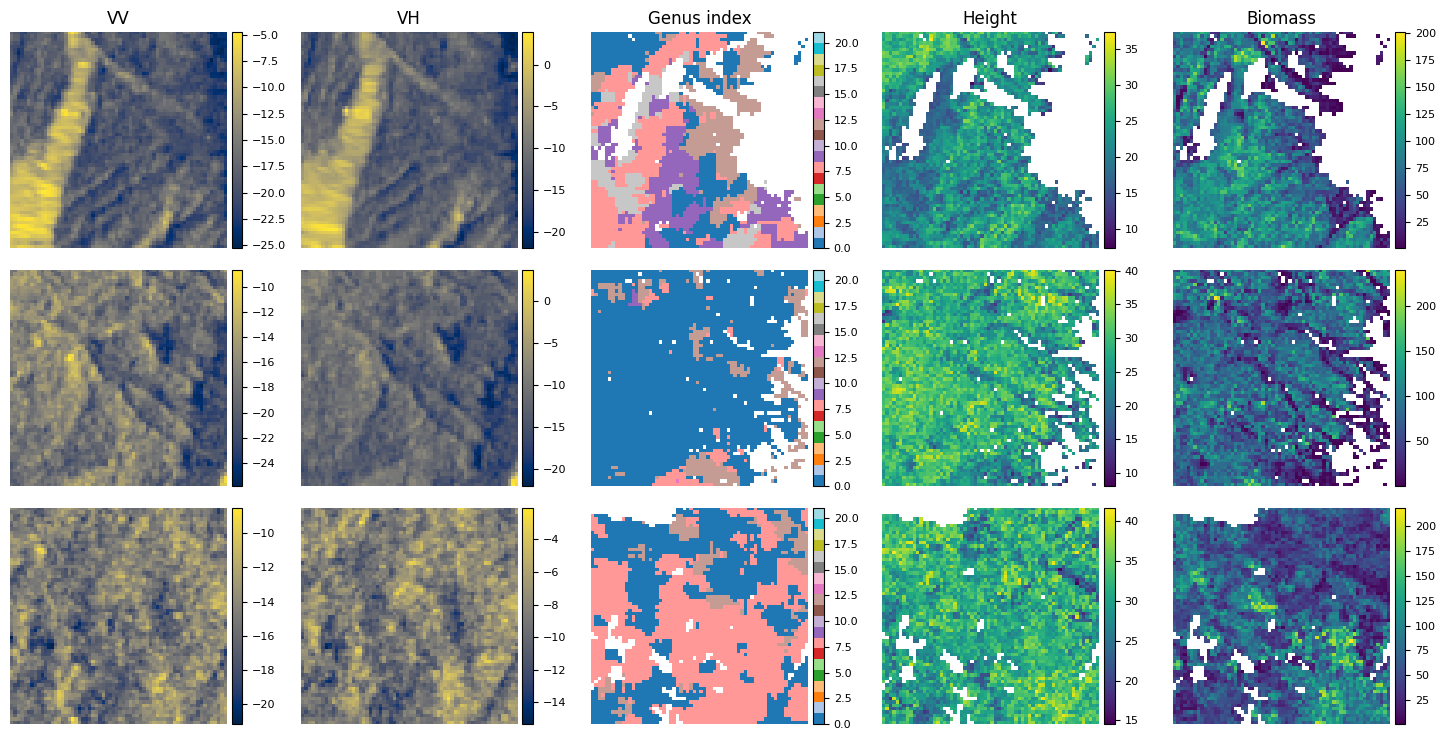

In [3]:
train_ds, val_ds, test_ds, num_classes, code_to_index, index_to_code, ignored_seg_class_indices = make_datasets(BASE_DIR)

train_loader = DataLoader(
    train_ds,
    batch_size=configs["batch_size"],
    shuffle=True,
    num_workers=2,
)
val_loader = DataLoader(
    val_ds,
    batch_size=configs["batch_size"],
    shuffle=False,
    num_workers=2,
)
test_loader = DataLoader(
    test_ds,
    batch_size=configs["batch_size"],
    shuffle=False,
    num_workers=2,
)

visualize_dataset_triplet_sample(
    train_ds,
    val_ds,
    test_ds,
    idx_train=72,
    idx_val=72,
    idx_test=72,
    num_classes=num_classes,
)

## Model

### Blocks

In [4]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        return self.block(x)


class Down(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        return self.block(x)


class Up(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.up = nn.ConvTranspose2d(
            in_channels,
            in_channels // 2,
            kernel_size=2,
            stride=2,
        )
        # after upsampling, features are concatenated with skip connection
        # so DoubleConv expects in_channels and produces out_channels
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        x = self.up(x)
        # shapes should match exactly (64 -> 32 -> 16 -> 8)
        if x.shape[-2:] != skip.shape[-2:]:
            # simple padding/cropping guard (should rarely trigger)
            min_h = min(x.shape[-2], skip.shape[-2])
            min_w = min(x.shape[-1], skip.shape[-1])
            x = x[..., :min_h, :min_w]
            skip = skip[..., :min_h, :min_w]
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

### UNet-based MTL

In [5]:

class MultiTaskUNet(nn.Module):
    """U-Net with shared encoder and three heads:

    - seg_head: genus segmentation (N, num_classes, 64, 64)
    - height_head: height regression (N, 1, 64, 64)
    - biomass_head: biomass regression (N, 1, 64, 64)
    """

    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        base_channels: int = 64,
        dropout: float = 0.2,
    ) -> None:
        super().__init__()

        self.num_classes = num_classes

        # Encoder: 64 -> 32 -> 16 -> 8
        self.enc1 = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)  # 64 -> 32
        self.enc2 = DoubleConv(base_channels * 2, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)  # 32 -> 16
        self.enc3 = DoubleConv(base_channels * 4, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)  # 16 -> 8
        self.bottleneck = DoubleConv(base_channels * 8, base_channels * 8)

        # Segmentation decoder
        self.up3_seg = Up(base_channels * 8, base_channels * 4)
        self.up2_seg = Up(base_channels * 4, base_channels * 2)
        self.up1_seg = Up(base_channels * 2, base_channels)
        self.drop_seg = nn.Dropout2d(p=dropout)
        self.out_seg = nn.Conv2d(base_channels, num_classes, kernel_size=1)

        # Height regression decoder
        self.up3_h = Up(base_channels * 8, base_channels * 4)
        self.up2_h = Up(base_channels * 4, base_channels * 2)
        self.up1_h = Up(base_channels * 2, base_channels)
        self.drop_h = nn.Dropout2d(p=dropout)
        self.out_h = nn.Conv2d(base_channels, 1, kernel_size=1)

        # Biomass regression decoder
        self.up3_b = Up(base_channels * 8, base_channels * 4)
        self.up2_b = Up(base_channels * 4, base_channels * 2)
        self.up1_b = Up(base_channels * 2, base_channels)
        self.drop_b = nn.Dropout2d(p=dropout)
        self.out_b = nn.Conv2d(base_channels, 1, kernel_size=1)

    def forward(self, x: torch.Tensor):  # type: ignore[override]
        # Shared encoder
        x1 = self.enc1(x)  # (N, C, 64, 64)
        x2 = self.down1(x1)  # (N, 2C, 32, 32)
        x2 = self.enc2(x2)
        x3 = self.down2(x2)  # (N, 4C, 16, 16)
        x3 = self.enc3(x3)
        x4 = self.down3(x3)  # (N, 8C, 8, 8)
        x5 = self.bottleneck(x4)

        # Segmentation branch
        s = self.up3_seg(x5, x3)
        s = self.up2_seg(s, x2)
        s = self.up1_seg(s, x1)
        s = self.drop_seg(s)
        seg_logits = self.out_seg(s)

        # Height branch
        h = self.up3_h(x5, x3)
        h = self.up2_h(h, x2)
        h = self.up1_h(h, x1)
        h = self.drop_h(h)
        height = self.out_h(h)

        # Biomass branch
        b = self.up3_b(x5, x3)
        b = self.up2_b(b, x2)
        b = self.up1_b(b, x1)
        b = self.drop_b(b)
        biomass = self.out_b(b)

        return seg_logits, height, biomass

## Functions

### Compute loss and metrics

In [6]:

def masked_rmse_loss(preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """RMSE ignoring NaN values in targets.

    preds, targets: (N, 1, H, W)
    """

    mask = torch.isfinite(targets)
    if not mask.any():
        return (preds * 0.0).sum()
    diff = preds[mask] - targets[mask]
    return torch.sqrt(torch.mean(diff ** 2))


def compute_allometry_loss(
    height_pred: torch.Tensor,
    biomass_pred: torch.Tensor,
    alpha: float,
    beta: float,
    min_height: float = 0.0,
) -> torch.Tensor:
    """Allometry-based regularizer between predicted height and biomass.

    Enforces a log-log relationship: log(B) ≈ alpha + beta * log(H).
    Uses only pixels with finite predictions and H > min_height.
    """

    eps = 1e-6
    h = torch.clamp(height_pred, min=eps)
    b = torch.clamp(biomass_pred, min=eps)

    log_h = torch.log(h)
    log_b = torch.log(b)
    log_b_allom = float(alpha) + float(beta) * log_h
    diff = log_b - log_b_allom

    mask = torch.isfinite(diff)
    if min_height is not None:
        mask = mask & (h > float(min_height))
    if not mask.any():
        return (height_pred * 0.0).sum()
    return torch.mean(diff[mask] ** 2)

def masked_r2(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    min_target: float | None = 0.0,
) -> float:
    """Compute R² on valid regression targets only (masked by forest pixels).

    - Always忽略非有限值 (NaN / inf)。
    - 如果 ``min_target`` 不为 None，则只在 ``y_true > min_target`` 的像元上计算，
      用于只在有效森林像元上评估。
    """

    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if min_target is not None:
        mask &= y_true > float(min_target)

    if not np.any(mask):
        return float("nan")

    y_true_m = y_true[mask]
    y_pred_m = y_pred[mask]

    return float(r2_score(y_true_m, y_pred_m))

def compute_segmentation_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    num_classes: int,
    ignore_index: int = IGNORE_INDEX,
):
    """Compute pixel accuracy, IoU and Dice for segmentation.

    y_true, y_pred: (N, H, W) integer arrays.
    Pixels with label == ``ignore_index`` in ``y_true`` are ignored everywhere,
    so they do not contribute to loss, metrics, or confusion matrix.
    """

    mask = y_true != ignore_index
    if not mask.any():
        return {
            "pixel_acc": float("nan"),
            "mean_iou": float("nan"),
            "per_class_iou": [float("nan")] * num_classes,
            "mean_dice": float("nan"),
            "per_class_dice": [float("nan")] * num_classes,
            "per_class_acc": [float("nan")] * num_classes,
        }

    y_true_flat = y_true[mask].ravel()
    y_pred_flat = y_pred[mask].ravel()

    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(num_classes))
    correct = np.diag(cm).astype(float)
    total = cm.sum().astype(float)
    pixel_acc = float(correct.sum() / total) if total > 0 else float("nan")

    # Per-class accuracy: TP / (TP + FN)
    row_sum = cm.sum(axis=1).astype(float)
    per_class_acc = np.where(row_sum > 0, correct / (row_sum + 1e-6), np.nan)

    # IoU per class
    union = cm.sum(axis=1) + cm.sum(axis=0) - correct
    iou = np.where(union > 0, correct / (union + 1e-6), np.nan)
    mean_iou = float(np.nanmean(iou))

    # Dice per class: 2TP / (2TP + FP + FN) = 2TP / (row + col)
    col_sum = cm.sum(axis=0).astype(float)
    denom = row_sum + col_sum
    dice = np.where(denom > 0, 2.0 * correct / (denom + 1e-6), np.nan)
    mean_dice = float(np.nanmean(dice))

    return {
        "pixel_acc": pixel_acc,
        "mean_iou": mean_iou,
        "per_class_iou": iou.tolist(),
        "mean_dice": mean_dice,
        "per_class_dice": dice.tolist(),
        "per_class_acc": per_class_acc.tolist(),
    }


### Training functions

In [67]:

def train_one_epoch_mtl(
    model: nn.Module,
    loader: DataLoader,
    seg_criterion: nn.Module,
    reg_criterion,
    optimizer: torch.optim.Optimizer,
    device: str,
    epoch: int | None = None,
    scheduler=None,
    weighting: str = "fixed",
    seg_weight: float = 1.0,
    height_weight: float = 1.0,
    biomass_weight: float = 1.0,
    uncertainty_params: torch.nn.Parameter | None = None,
    gradnorm_state: dict | None = None,
    allom_alpha: float = 0.0,
    allom_beta: float = 1.0,
    allom_weight: float = 0.0,
    allom_min_height: float = 0.0,
):
    """Train one epoch of true multi-task learning with three heads.

    Supports three weighting strategies:
        - "fixed": constant weights from seg_weight / height_weight / biomass_weight
        - "uncertainty": Kendall-style homoscedastic uncertainty weighting
        - "gradnorm": GradNorm dynamic weighting on shared parameters
    and an additional allometry-based regularizer between height and biomass.
    """

    model.train()
    total_loss = 0.0
    total_seg_loss = 0.0
    total_h_loss = 0.0
    total_b_loss = 0.0
    total_allom_loss = 0.0
    total_samples = 0

    desc = f"Train MTL {epoch}" if epoch is not None else "Train MTL"

    for x, y_seg, y_h, y_b in tqdm(loader, desc=desc):
        x = x.to(device)
        y_seg = y_seg.to(device)
        y_h = y_h.to(device)
        y_b = y_b.to(device)

        seg_logits, h_pred, b_pred = model(x)

        loss_seg = seg_criterion(seg_logits, y_seg)
        loss_h = reg_criterion(h_pred, y_h)
        loss_b = reg_criterion(b_pred, y_b)

        task_losses = torch.stack([loss_seg, loss_h, loss_b])

        if allom_weight > 0.0:
            allom_loss = compute_allometry_loss(
                h_pred,
                b_pred,
                alpha=allom_alpha,
                beta=allom_beta,
                min_height=allom_min_height,
            )
        else:
            allom_loss = loss_seg * 0.0

        if weighting == "fixed":
            w = torch.tensor(
                [float(seg_weight), float(height_weight), float(biomass_weight)],
                device=task_losses.device,
                dtype=task_losses.dtype,
            )
            task_part = torch.sum(w * task_losses)

        elif weighting == "uncertainty":
            if uncertainty_params is None:
                raise ValueError("uncertainty_params must be provided when weighting='uncertainty'")
            s = uncertainty_params
            if s.numel() != 3:
                raise ValueError("uncertainty_params must have 3 elements (seg / height / biomass)")
            task_part = 0.0 * task_losses[0]
            for i in range(3):
                weight_i = 0.5 * torch.exp(-s[i])
                task_part = task_part + weight_i * task_losses[i] + 0.5 * s[i]

        elif weighting == "gradnorm":
            if gradnorm_state is None:
                raise ValueError("gradnorm_state must be provided when weighting='gradnorm'")
            w_param = gradnorm_state["weights"]
            shared_param = gradnorm_state["shared_param"]
            alpha_gn = float(gradnorm_state.get("alpha", 0.5))
            opt_w = gradnorm_state["optimizer"]

            if gradnorm_state["L0"] is None:
                gradnorm_state["L0"] = task_losses.detach().cpu()

            w = torch.clamp(w_param, min=1e-3)

            G_list = []
            for i in range(3):
                optimizer.zero_grad()
                opt_w.zero_grad()
                grad = torch.autograd.grad(
                    w[i] * task_losses[i],
                    shared_param,
                    retain_graph=True,
                    create_graph=True,
                )[0]
                G_list.append(grad.norm(2))

            G = torch.stack(G_list)
            G_avg = G.mean().detach()

            L0 = gradnorm_state["L0"].to(task_losses.device)
            loss_ratios = task_losses.detach() / (L0 + 1e-8)
            inv_train_rate = loss_ratios / (loss_ratios.mean() + 1e-8)
            target_G = G_avg * (inv_train_rate ** alpha_gn)

            gradnorm_loss = torch.sum(torch.abs(G - target_G))
            opt_w.zero_grad()
            gradnorm_loss.backward(retain_graph=True)
            opt_w.step()

            w = torch.clamp(w_param, min=1e-3).detach()
            task_part = torch.sum(w * task_losses)

        else:
            raise ValueError(f"Unknown weighting strategy: {weighting}")

        loss = task_part + float(allom_weight) * allom_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        bs = x.size(0)
        total_loss += float(loss.item()) * bs
        total_seg_loss += float(loss_seg.item()) * bs
        total_h_loss += float(loss_h.item()) * bs
        total_b_loss += float(loss_b.item()) * bs
        total_allom_loss += float(allom_loss.item()) * bs
        total_samples += bs

    avg_loss = total_loss / max(total_samples, 1)
    avg_seg_loss = total_seg_loss / max(total_samples, 1)
    avg_h_loss = total_h_loss / max(total_samples, 1)
    avg_b_loss = total_b_loss / max(total_samples, 1)
    avg_allom_loss = total_allom_loss / max(total_samples, 1)

    return {
        "loss": avg_loss,
        "seg_loss": avg_seg_loss,
        "height_loss": avg_h_loss,
        "biomass_loss": avg_b_loss,
        "allom_loss": avg_allom_loss,
    }



In [20]:

def evaluate(
    model: nn.Module,
    loader: DataLoader,
    seg_criterion: nn.Module,
    reg_criterion,
    device: str,
    desc: str = "Eval",
    seg_weight: float = 1.0,
    height_weight: float = 1.0,
    biomass_weight: float = 1.0,
    num_classes: int = 1,
    ignore_index: int = IGNORE_INDEX,
    allom_alpha: float | None = None,
    allom_beta: float | None = None,
    allom_min_height: float = 0.0,
    allom_weight: float = 0.0,
):
    model.eval()
    total_loss = 0.0
    total_task_loss = 0.0
    total_seg_loss = 0.0
    total_h_loss = 0.0
    total_b_loss = 0.0
    total_allom_loss = 0.0
    total_samples = 0

    all_true_seg = []
    all_pred_seg = []
    all_true_h = []
    all_pred_h = []
    all_true_b = []
    all_pred_b = []

    with torch.no_grad():
        for x, y_seg, y_h, y_b in tqdm(loader, desc=desc):
            x = x.to(device)
            y_seg = y_seg.to(device)
            y_h = y_h.to(device)
            y_b = y_b.to(device)

            seg_logits, h_pred, b_pred = model(x)

            loss_seg = seg_criterion(seg_logits, y_seg)
            loss_h = reg_criterion(h_pred, y_h)
            loss_b = reg_criterion(b_pred, y_b)

            # Task part of the loss (seg/height/biomass)
            task_loss = (
                seg_weight * loss_seg
                + height_weight * loss_h
                + biomass_weight * loss_b
            )

            # Allometry regularizer (for logging only, no backprop here)
            if (
                allom_alpha is not None
                and allom_beta is not None
                and allom_weight > 0.0
            ):
                allom_loss = compute_allometry_loss(
                    h_pred,
                    b_pred,
                    alpha=allom_alpha,
                    beta=allom_beta,
                    min_height=allom_min_height,
                )
            else:
                allom_loss = task_loss * 0.0

            loss = task_loss + float(allom_weight) * allom_loss

            bs = x.size(0)
            total_loss += float(loss.item()) * bs
            total_task_loss += float(task_loss.item()) * bs
            total_seg_loss += float(loss_seg.item()) * bs
            total_h_loss += float(loss_h.item()) * bs
            total_b_loss += float(loss_b.item()) * bs
            total_allom_loss += float(allom_loss.item()) * bs
            total_samples += bs

            # Segmentation predictions
            seg_pred = torch.argmax(seg_logits, dim=1)  # (N, H, W)
            all_true_seg.append(y_seg.cpu().numpy())
            all_pred_seg.append(seg_pred.cpu().numpy())

            # Regression targets/predictions
            all_true_h.append(y_h.cpu().numpy())
            all_pred_h.append(h_pred.cpu().numpy())
            all_true_b.append(y_b.cpu().numpy())
            all_pred_b.append(b_pred.cpu().numpy())

    avg_loss = total_loss / max(total_samples, 1)          # 含 allom 的总 loss
    avg_task_loss = total_task_loss / max(total_samples, 1)
    avg_seg_loss = total_seg_loss / max(total_samples, 1)
    avg_h_loss = total_h_loss / max(total_samples, 1)
    avg_b_loss = total_b_loss / max(total_samples, 1)
    avg_allom_loss = total_allom_loss / max(total_samples, 1)

    y_true_seg = np.concatenate(all_true_seg, axis=0)
    y_pred_seg = np.concatenate(all_pred_seg, axis=0)
    seg_metrics = compute_segmentation_metrics(
        y_true_seg, y_pred_seg, num_classes=num_classes, ignore_index=ignore_index
    )

    def _flatten_valid(arr_list):
        arr = np.concatenate(arr_list, axis=0)  # (N, 1, H, W)
        arr = arr.reshape(-1)
        return arr

    # Height metrics (only valid forest pixels: y_true > 0 by default)
    h_true = _flatten_valid(all_true_h)
    h_pred = _flatten_valid(all_pred_h)
    h_mask = np.isfinite(h_true) & np.isfinite(h_pred) & (h_true > 0.0)
    if np.any(h_mask):
        h_true_m = h_true[h_mask]
        h_pred_m = h_pred[h_mask]
        h_rmse = float(math.sqrt(float(np.mean((h_pred_m - h_true_m) ** 2))))
    else:
        h_rmse = float("nan")
    h_r2 = masked_r2(h_true, h_pred, min_target=0.0)

    # Biomass metrics (only valid forest pixels: y_true > 0 by default)
    b_true = _flatten_valid(all_true_b)
    b_pred = _flatten_valid(all_pred_b)
    b_mask = np.isfinite(b_true) & np.isfinite(b_pred) & (b_true > 0.0)
    if np.any(b_mask):
        b_true_m = b_true[b_mask]
        b_pred_m = b_pred[b_mask]
        b_rmse = float(math.sqrt(float(np.mean((b_pred_m - b_true_m) ** 2))))
    else:
        b_rmse = float("nan")
    b_r2 = masked_r2(b_true, b_pred, min_target=0.0)

    metrics = {
            "loss": avg_loss,               # total loss = task + allom_weight * allom
            "task_loss": avg_task_loss,     # only seg/height/biomass part
            "seg_loss": avg_seg_loss,
            "height_loss": avg_h_loss,
            "biomass_loss": avg_b_loss,
            "allom_loss": avg_allom_loss,
            "pixel_acc": seg_metrics["pixel_acc"],
            "mean_iou": seg_metrics["mean_iou"],
            "mean_dice": seg_metrics["mean_dice"],
            "height_rmse": h_rmse,
            "height_r2": h_r2,
            "biomass_rmse": b_rmse,
            "biomass_r2": b_r2,
        }

    return metrics, seg_metrics


In [9]:

def evaluate(
    model: nn.Module,
    loader: DataLoader,
    seg_criterion: nn.Module,
    reg_criterion,
    device: str,
    desc: str = "Eval",
    seg_weight: float = 1.0,
    height_weight: float = 1.0,
    biomass_weight: float = 1.0,
    num_classes: int = 1,
    ignore_index: int = IGNORE_INDEX,
):
    model.eval()
    total_loss = 0.0
    total_seg_loss = 0.0
    total_h_loss = 0.0
    total_b_loss = 0.0
    total_samples = 0

    all_true_seg = []
    all_pred_seg = []
    all_true_h = []
    all_pred_h = []
    all_true_b = []
    all_pred_b = []

    with torch.no_grad():
        for x, y_seg, y_h, y_b in tqdm(loader, desc=desc):
            x = x.to(device)
            y_seg = y_seg.to(device)
            y_h = y_h.to(device)
            y_b = y_b.to(device)

            seg_logits, h_pred, b_pred = model(x)

            loss_seg = seg_criterion(seg_logits, y_seg)
            loss_h = reg_criterion(h_pred, y_h)
            loss_b = reg_criterion(b_pred, y_b)
            loss = seg_weight * loss_seg + height_weight * loss_h + biomass_weight * loss_b

            bs = x.size(0)
            total_loss += float(loss.item()) * bs
            total_seg_loss += float(loss_seg.item()) * bs
            total_h_loss += float(loss_h.item()) * bs
            total_b_loss += float(loss_b.item()) * bs
            total_samples += bs

            # Segmentation predictions
            seg_pred = torch.argmax(seg_logits, dim=1)  # (N, H, W)
            all_true_seg.append(y_seg.cpu().numpy())
            all_pred_seg.append(seg_pred.cpu().numpy())

            # Regression targets/predictions
            all_true_h.append(y_h.cpu().numpy())
            all_pred_h.append(h_pred.cpu().numpy())
            all_true_b.append(y_b.cpu().numpy())
            all_pred_b.append(b_pred.cpu().numpy())

    avg_loss = total_loss / max(total_samples, 1)
    avg_seg_loss = total_seg_loss / max(total_samples, 1)
    avg_h_loss = total_h_loss / max(total_samples, 1)
    avg_b_loss = total_b_loss / max(total_samples, 1)

    y_true_seg = np.concatenate(all_true_seg, axis=0)
    y_pred_seg = np.concatenate(all_pred_seg, axis=0)
    seg_metrics = compute_segmentation_metrics(
        y_true_seg, y_pred_seg, num_classes=num_classes, ignore_index=ignore_index
    )

    def _flatten_valid(arr_list):
        arr = np.concatenate(arr_list, axis=0)  # (N, 1, H, W)
        arr = arr.reshape(-1)
        return arr

    # Height metrics (only valid forest pixels: y_true > 0 by default)
    h_true = _flatten_valid(all_true_h)
    h_pred = _flatten_valid(all_pred_h)
    h_mask = np.isfinite(h_true) & np.isfinite(h_pred) & (h_true > 0.0)
    if np.any(h_mask):
        h_true_m = h_true[h_mask]
        h_pred_m = h_pred[h_mask]
        h_rmse = float(math.sqrt(float(np.mean((h_pred_m - h_true_m) ** 2))))
    else:
        h_rmse = float("nan")
    h_r2 = masked_r2(h_true, h_pred, min_target=0.0)

    # Biomass metrics (only valid forest pixels: y_true > 0 by default)
    b_true = _flatten_valid(all_true_b)
    b_pred = _flatten_valid(all_pred_b)
    b_mask = np.isfinite(b_true) & np.isfinite(b_pred) & (b_true > 0.0)
    if np.any(b_mask):
        b_true_m = b_true[b_mask]
        b_pred_m = b_pred[b_mask]
        b_rmse = float(math.sqrt(float(np.mean((b_pred_m - b_true_m) ** 2))))
    else:
        b_rmse = float("nan")
    b_r2 = masked_r2(b_true, b_pred, min_target=0.0)

    metrics = {
        "loss": avg_loss,
        "seg_loss": avg_seg_loss,
        "height_loss": avg_h_loss,
        "biomass_loss": avg_b_loss,
        "pixel_acc": seg_metrics["pixel_acc"],
        "mean_iou": seg_metrics["mean_iou"],
        "mean_dice": seg_metrics["mean_dice"],
        "height_rmse": h_rmse,
        "height_r2": h_r2,
        "biomass_rmse": b_rmse,
        "biomass_r2": b_r2,
    }

    return metrics, seg_metrics

## Visualization

In [34]:

def visualize_segmentation_samples(
    model: nn.Module,
    dataset: IMAESTROSegDataset,
    start_idx: int = 0,
    num_samples: int = 4,
    device: str = device,
    num_classes: int = num_classes,
) -> None:
    """Visualize VV/VH and segmentation (true & pred) for a few samples.

    Each row shows (VV, VH, true segmentation, predicted segmentation).
    VV/VH use the "cividis" colormap, segmentation uses a discrete colormap.
    """

    model.eval()

    start_idx = int(start_idx)
    num_samples = int(num_samples)
    end_idx = min(start_idx + num_samples, len(dataset))
    if end_idx <= start_idx:
        print("No samples to visualize.")
        return

    n = end_idx - start_idx

    inputs = dataset.inputs[start_idx:end_idx].to(device)
    targets_seg = dataset.seg_targets[start_idx:end_idx]

    with torch.no_grad():
        out = model(inputs)
        if isinstance(out, tuple):
            seg_logits = out[0]
        else:
            seg_logits = out
        preds_seg = torch.argmax(seg_logits, dim=1)

    inputs_np = inputs.cpu().numpy()
    targets_np = targets_seg.cpu().numpy()
    preds_np = preds_seg.cpu().numpy()

    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(3 * 4, 2.5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for row in range(n):
        row_axes = axes[row]

        band_vv = inputs_np[row, 1, :, :]
        band_vh = inputs_np[row, 0, :, :]
        seg_true = targets_np[row]
        seg_pred = preds_np[row]

        # True labels: ignore invalid / IGNORE_INDEX (already includes rare genera)
        mask_invalid_true = ~np.isfinite(seg_true) | (seg_true == IGNORE_INDEX)
        seg_true_plot = np.ma.array(seg_true, mask=mask_invalid_true)

        # Predictions: additionally mask out rare classes using ignored_seg_class_indices
        # so that we only visualize non-rare genera.
        if 'ignored_seg_class_indices' in globals() and ignored_seg_class_indices is not None:
            mask_pred_rare = np.isin(seg_pred, ignored_seg_class_indices)
        else:
            mask_pred_rare = np.zeros_like(seg_pred, dtype=bool)

        # Also hide predictions wherever seg_true is invalid (NaN or IGNORE_INDEX)
        mask_true_invalid = ~np.isfinite(seg_true) | (seg_true == IGNORE_INDEX)

        mask_invalid_pred = ~np.isfinite(seg_pred) | mask_pred_rare | mask_true_invalid
        seg_pred_plot = np.ma.array(seg_pred, mask=mask_invalid_pred)

        images = [band_vv, band_vh, seg_true_plot, seg_pred_plot]
        titles = ["VV", "VH", "Seg true", "Seg pred"]

        for col in range(4):
            ax = row_axes[col]
            band = images[col]

            if col < 2:
                cmap = "cividis"
                im = ax.imshow(band, cmap=cmap)
            else:
                cmap = plt.get_cmap("tab20").copy()
                cmap.set_bad(color="white")
                im = ax.imshow(
                    band,
                    cmap=cmap,
                    vmin=0,
                    vmax=max(num_classes - 1, 1),
                )

            if row == 0:
                ax.set_title(titles[col])
            ax.axis("off")

            # Colorbar: for segmentation panels, only show ticks for classes
            # actually present in this image, and label them with genus codes.
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
            if col < 2:
                # VV / VH: use 5 ticks with 1-decimal labels (similar to regression plots)
                vmin = float(np.nanmin(band))
                vmax = float(np.nanmax(band))
                if not np.isfinite(vmin) or not np.isfinite(vmax):
                    vmin, vmax = 0.0, 1.0
                im.set_clim(vmin, vmax)
                ticks = np.linspace(vmin, vmax, 5)
                cbar.set_ticks(ticks)
                cbar.set_ticklabels([f"{t:.1f}" for t in ticks])
                cbar.ax.tick_params(labelsize=8)
            else:
                if col == 2:
                    raw = seg_true
                    mask_used = mask_invalid_true
                else:
                    raw = seg_pred
                    mask_used = mask_invalid_pred

                valid = raw[~mask_used]
                if valid.size == 0:
                    # No valid classes in this panel
                    cbar.set_ticks([])
                else:
                    present_indices = np.unique(valid.astype(int))
                    ticks = present_indices
                    # Map class index -> genus code if available
                    labels = []
                    for cls in present_indices:
                        if 'index_to_code' in globals():
                            code = index_to_code.get(int(cls), int(cls))
                        else:
                            code = int(cls)
                        labels.append(str(code))
                    cbar.set_ticks(ticks)
                    cbar.set_ticklabels(labels)
                cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    plt.show()

"""### regression samples"""

def visualize_regression_samples(
    model: nn.Module,
    dataset: IMAESTROSegDataset,
    start_idx: int = 0,
    num_samples: int = 4,
    device: str = device,
    target: str = "height",
) -> None:
    """Visualize VV/VH and regression target (true/pred) for a few samples.

    target: "height" or "biomass".

    For regression-only models, `model(x)` should return (N, 1 or 2, H, W).
    For multi-task models, it can return (seg_logits, height, biomass).
    """

    model.eval()

    start_idx = int(start_idx)
    num_samples = int(num_samples)
    end_idx = min(start_idx + num_samples, len(dataset))
    if end_idx <= start_idx:
        print("No samples to visualize.")
        return

    n = end_idx - start_idx

    inputs = dataset.inputs[start_idx:end_idx].to(device)
    targets_h = dataset.height_targets[start_idx:end_idx]
    targets_b = dataset.biomass_targets[start_idx:end_idx]

    with torch.no_grad():
        out = model(inputs)
        if isinstance(out, tuple):
            _, preds_h, preds_b = out
        else:
            preds = out
            if preds.shape[1] == 1:
                preds_h = preds
                preds_b = preds
            else:
                preds_h = preds[:, 0:1, ...]
                preds_b = preds[:, 1:2, ...]

        if target == "height":
            preds_t = preds_h
        else:
            preds_t = preds_b

    inputs_np = inputs.cpu().numpy()
    if target == "height":
        targets_np = targets_h.cpu().numpy()[:, 0, :, :]
    else:
        targets_np = targets_b.cpu().numpy()[:, 0, :, :]
    preds_np = preds_t.cpu().numpy()[:, 0, :, :]

    s1_list = []
    h_list = []

    for row in range(n):
        band_vh = inputs_np[row, 0, :, :]
        band_vv = inputs_np[row, 1, :, :]
        denom = np.where(np.abs(band_vh) < 1e-6, 1e-6, band_vh)
        h_true = targets_np[row]
        h_pred = preds_np[row]

        s1_list.append(np.stack([band_vv, band_vh], axis=0))
        h_list.append(np.stack([h_true, h_pred], axis=0))

    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(3.1 * 4, 2.5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for row in range(n):
        row_axes = axes[row]

        band_vv, band_vh = s1_list[row]
        h_true, h_pred = h_list[row]

        # Use the same mask for true and pred: hide pixels where true is NaN / non-finite
        mask_invalid = ~np.isfinite(h_true)
        h_true_plot = np.ma.array(h_true, mask=mask_invalid)
        h_pred_plot = np.ma.array(h_pred, mask=mask_invalid)

        # Shared color range for true & pred based on their combined valid values
        if np.any(~mask_invalid):
            combined_vals = np.concatenate(
                [h_true[~mask_invalid].ravel(), h_pred[~mask_invalid].ravel()]
            )
            vmin_h = float(np.nanmin(combined_vals))
            vmax_h = float(np.nanmax(combined_vals))
            if not np.isfinite(vmin_h) or not np.isfinite(vmax_h):
                vmin_h, vmax_h = 0.0, 1.0
        else:
            vmin_h, vmax_h = 0.0, 1.0

        images = [band_vv, band_vh, h_true_plot, h_pred_plot]
        if target == "height":
            titles = ["VV", "VH", "Height true", "Height pred"]
        else:
            titles = ["VV", "VH", "Biomass true", "Biomass pred"]

        for col in range(4):
            ax = row_axes[col]
            band = images[col]
            cmap = "cividis" if col < 2 else "viridis"

            im = ax.imshow(band, cmap=cmap)
            if row < 1:
                ax.set_title(titles[col])
            ax.axis("off")

            if col < 3:
                vmin = float(np.nanmin(band))
                vmax = float(np.nanmax(band))
                if not np.isfinite(vmin) or not np.isfinite(vmax):
                    vmin, vmax = 0.0, 1.0
                im.set_clim(vmin, vmax)

                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
                ticks = np.linspace(vmin, vmax, 5)
                cbar.set_ticks(ticks)
                cbar.set_ticklabels([f"{t:.1f}" for t in ticks])
                cbar.ax.tick_params(labelsize=9)
            else:
                im.set_clim(vmin_h, vmax_h)

                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
                ticks = np.linspace(vmin_h, vmax_h, 5)
                cbar.set_ticks(ticks)
                cbar.set_ticklabels([f"{t:.1f}" for t in ticks])
                cbar.ax.tick_params(labelsize=9)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.001)
    plt.show()

def plot_cm(
    model: nn.Module,
    loader: DataLoader = test_loader,
    device: str = device,
    num_classes: int = num_classes,
    ignore_index: int = IGNORE_INDEX,
):
    """Plot confusion matrix for segmentation predictions on the test set.

    Works with SegmentationUNet or MultiTaskUNet (uses segmentation head).
    """

    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for x, y_seg, _, _ in tqdm(loader, desc="Test features for confusion"):
            x = x.to(device)
            y_seg = y_seg.to(device)

            out = model(x)
            if isinstance(out, tuple):
                seg_logits = out[0]
            else:
                seg_logits = out

            seg_pred = torch.argmax(seg_logits, dim=1)

            y_true_np = y_seg.cpu().numpy()
            y_pred_np = seg_pred.cpu().numpy()

            mask = y_true_np != ignore_index
            all_true.append(y_true_np[mask])
            all_pred.append(y_pred_np[mask])

    if not all_true:
        print("No valid pixels for confusion matrix.")
        return

    y_true_flat = np.concatenate(all_true, axis=0).ravel()
    y_pred_flat = np.concatenate(all_pred, axis=0).ravel()

    cm_dom = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(num_classes))

    class_labels = [str(index_to_code[i]) for i in range(num_classes)]

    plt.figure(figsize=(12, 5))
    ax = sns.heatmap(
        cm_dom,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.xlabel("Predicted genus index")
    plt.ylabel("True genus index")
    plt.tight_layout()
    plt.show()

"""### segmentation report"""

def print_segmentation_report(
    seg_metrics: dict,
    index_to_code: dict[int, int],
    ignored_indices: list[int] | None = None,
):
    """Print per-genus IoU and Dice based on segmentation metrics.

    ``seg_metrics`` is the dict returned by :func:`compute_segmentation_metrics`.
    Classes whose index is in ``ignored_indices`` are skipped.
    """

    per_iou = np.array(seg_metrics.get("per_class_iou", []), dtype=float)
    per_dice = np.array(seg_metrics.get("per_class_dice", []), dtype=float)
    per_acc = np.array(seg_metrics.get("per_class_acc", []), dtype=float)
    num_classes = max(per_iou.shape[0], per_dice.shape[0], per_acc.shape[0])

    if num_classes == 0:
        print("No per-class segmentation metrics available.")
        return

    ignored_set = set(ignored_indices or [])

    # Build mapping from genus code -> genus name using genus_map.json
    genus_map_path = BASE_DIR + "/genus_map.json"
    with open(genus_map_path, "r", encoding="utf-8") as f:
        genus_to_code = json.load(f)
    code_to_genus = {int(v): str(k) for k, v in genus_to_code.items()}

    header = f"{'Idx':>3}  {'GenusCode':>9}  {'GenusName':>12}  {'Acc':>8}  {'IoU':>8}  {'Dice':>8}"
    print("\nPer-genus segmentation metrics (excluding ignored/rare/empty classes):")
    print(header)
    print("-" * len(header))

    for idx in range(num_classes):
        if idx in ignored_set:
            continue
        iou = per_iou[idx] if idx < per_iou.size else np.nan
        dice = per_dice[idx] if idx < per_dice.size else np.nan
        acc = per_acc[idx] if idx < per_acc.size else np.nan

        # No support for this class in the evaluation data
        if not (np.isfinite(iou) or np.isfinite(dice) or np.isfinite(acc)):
            continue

        genus_code = index_to_code.get(idx, None)
        genus_name = code_to_genus.get(genus_code, None) if genus_code is not None else None

        # Skip rare genera by name if available
        if genus_name is not None and genus_name.lower() in RARE_GENUS_NAMES:
            continue

        genus_code_str = str(genus_code) if genus_code is not None else f"idx_{idx}"
        genus_name_str = genus_name if genus_name is not None else "-"

        acc_str = f"{acc:8.4f}" if np.isfinite(acc) else "   nan   "
        iou_str = f"{iou:8.4f}" if np.isfinite(iou) else "   nan   "
        dice_str = f"{dice:8.4f}" if np.isfinite(dice) else "   nan   "
        print(f"{idx:3d}  {genus_code_str:>9}  {genus_name_str:>12}  {acc_str}  {iou_str}  {dice_str}")

'### scatter plot'

### curve

In [121]:
def plot_curves(history: dict, task: str = "mtl", target: str = "height"):
    """Plot training dynamics for the MTL model.

    First figure (1x5):
        - total loss (train/val)
        - segmentation loss (train/val)
        - height regression loss (train/val)
        - biomass regression loss (train/val)
        - allometry loss (train/val, if available)

    Second figure (1x4):
        - segmentation metrics (pixel acc / mIoU / mDice)
        - height regression metrics (R2)
        - biomass regression metrics (R2)
        - learning rate
    """

    epochs = history.get("epoch", [])

    # ----- Figure 1: Loss breakdown -----
    fig1, axes1 = plt.subplots(1, 5, figsize=(5 * 4, 3.5))
    titles = [
        "Total loss",
        "Seg loss",
        "Height loss",
        "Biomass loss",
        "Allom loss",
    ]
    train_keys = [
        "train_loss",
        "train_seg_loss",
        "train_height_loss",
        "train_biomass_loss",
        "train_allom_loss",
    ]
    val_keys = [
        "val_loss",
        "val_seg_loss",
        "val_height_loss",
        "val_biomass_loss",
        "val_allom_loss",
    ]

    for ax, title, tk, vk in zip(axes1, titles, train_keys, val_keys):
        # Plot train curve (clip to common length if needed)
        if tk in history:
            y_train = history[tk]
            n = min(len(epochs), len(y_train))
            if n > 0:
                ax.plot(epochs[:n], y_train[:n], label="train")

        # Plot val curve (clip to common length if needed)
        if vk in history:
            y_val = history[vk]
            n = min(len(epochs), len(y_val))
            if n > 0:
                ax.plot(epochs[:n], y_val[:n], label="val")
        ax.set_title(title)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True)
        ax.legend(fontsize=7)

    plt.tight_layout()
    plt.show()

 # ----- Figure 2: Metrics + LR + Weights -----
    fig2, axes2 = plt.subplots(1, 5, figsize=(5 * 4, 3.5))

    # Segmentation metrics
    ax = axes2[0]
    if "val_pixel_acc" in history:
        y = history["val_pixel_acc"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="pixel_acc")
    if "val_mean_iou" in history:
        y = history["val_mean_iou"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="mean_iou")
    if "val_mean_dice" in history:
        y = history["val_mean_dice"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="mean_dice")
    ax.set_title("Segmentation (val)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Metric")
    ax.grid(True)
    ax.legend(fontsize=7)

    # Height regression metrics
    ax = axes2[1]
    if "val_height_r2" in history:
        y = history["val_height_r2"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="height_R2")
    ax.set_title("Height (val)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("R2")
    ax.grid(True)
    ax.legend(fontsize=7)

    # Biomass regression metrics
    ax = axes2[2]
    if "val_biomass_r2" in history:
        y = history["val_biomass_r2"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="biomass_R2")
    ax.set_title("Biomass (val)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("R2")
    ax.grid(True)
    ax.legend(fontsize=7)

    # Learning rate
    ax = axes2[3]
    if "lr" in history:
        y = history["lr"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="lr")
    ax.set_title("Learning rate")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("LR")
    ax.grid(True)
    ax.legend(fontsize=7)

    # Task / allometry weights
    ax = axes2[4]
    if "seg_weight" in history:
        y = history["seg_weight"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="seg_w")
    if "height_weight" in history:
        y = history["height_weight"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="h_w")
    if "biomass_weight" in history:
        y = history["biomass_weight"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="b_w")
    if "allom_weight" in history:
        y = history["allom_weight"]
        n = min(len(epochs), len(y))
        if n > 0:
            ax.plot(epochs[:n], y[:n], label="allom_w")
    ax.set_title("Task / allom weights")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Weight")
    ax.grid(True)
    ax.legend(fontsize=7)

    plt.tight_layout()
    plt.show()


### scatter plots

In [36]:

def collect_regression_pairs(
    model: nn.Module,
    loader: DataLoader = test_loader,
    device: str = device,
    target: str = "height",
    min_target: float | None = 0.0,
):
    """Collect (y_true, y_pred) pairs for a regression target from a loader.

    Parameters
    ----------
    model : nn.Module
        Trained regression or multi-task model.
    loader : DataLoader
        Any loader over ``IMAESTROSegDataset`` (e.g., train/val/test loader).
    target : {"height", "biomass"}
        Which regression target to extract.
    min_target : float or None, default 0.0
        Optional lower bound on ``y_true`` to keep only "valid forest" pixels.
    """

    model.eval()
    ys = []
    ps = []
    with torch.no_grad():
        for x, _, y_h, y_b in tqdm(loader, desc="Collect reg pairs"):
            x = x.to(device)
            y_h = y_h.to(device)
            y_b = y_b.to(device)

            out = model(x)
            if isinstance(out, tuple):
                _, h_pred, b_pred = out
            else:
                preds = out
                if preds.shape[1] == 1:
                    h_pred = preds
                    b_pred = preds
                else:
                    h_pred = preds[:, 0:1, ...]
                    b_pred = preds[:, 1:2, ...]

            if target == "height":
                targets = y_h
                preds_t = h_pred
            else:
                targets = y_b
                preds_t = b_pred

            mask = torch.isfinite(targets)
            if min_target is not None:
                mask = mask & (targets >= float(min_target))
            if mask.any():
                ys.append(targets[mask].detach().cpu().numpy())
                ps.append(preds_t[mask].detach().cpu().numpy())

    if not ys:
        return np.empty(0, dtype=np.float32), np.empty(0, dtype=np.float32)
    y_true = np.concatenate(ys, axis=0)
    y_pred = np.concatenate(ps, axis=0)
    return y_true, y_pred

def plot_regression_joint_with_hists(
    y_true,
    y_pred,
    xlabel: str = "True value",
    ylabel: str = "Predicted value",
    max_value=None,
    bins: int = 40,
):
    """Joint scatter + hist plots for regression pairs (similar to original CHM plot)."""

    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if max_value is not None:
        mask &= y_true <= max_value
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    if y_true.size == 0:
        print("No valid data to plot.")
        return

    # Use the same masked forest definition as other regression metrics
    mask_forest = np.isfinite(y_true) & np.isfinite(y_pred) & (y_true > 0.0)
    if np.any(mask_forest):
        y_true_m = y_true[mask_forest]
        y_pred_m = y_pred[mask_forest]
        rmse = float(np.sqrt(np.mean((y_pred_m - y_true_m) ** 2)))
    else:
        rmse = float("nan")
    r2 = masked_r2(y_true, y_pred, min_target=0.0)

    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(
        2,
        2,
        width_ratios=(4, 0.8),
        height_ratios=(0.8, 4),
        wspace=0.05,
        hspace=0.05,
    )

    ax_histx = fig.add_subplot(gs[0, 0])
    ax_joint = fig.add_subplot(gs[1, 0])
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_joint)

    ax_histx.hist(
        y_true,
        bins=bins,
        color="#1f77b4",
        edgecolor="black",
        linewidth=0.5,
    )
    ax_histx.set_ylabel("Count")
    ax_histx.tick_params(labelbottom=False)
    ax_histx.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

    ax_histy.hist(
        y_pred,
        bins=bins,
        orientation="horizontal",
        color="#1f77b4",
        edgecolor="black",
        linewidth=0.5,
    )
    ax_histy.tick_params(labelleft=False)
    ax_histy.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

    if max_value is None:
        min_plot = 0.0
        max_plot = max(float(y_true.max()), float(y_pred.max()))
    else:
        min_plot = 0.0
        max_plot = float(max_value)
        ax_histx.set_xlim(min_plot, max_plot)
        ax_histy.set_ylim(min_plot, max_plot)

    ax_joint.hexbin(
        y_true,
        y_pred,
        gridsize=200,
        cmap="turbo",
        mincnt=1,
    )
    ax_joint.plot(
        [min_plot, max_plot],
        [min_plot, max_plot],
        linestyle="--",
        color="k",
        linewidth=1.0,
    )
    ax_joint.set_xlim(min_plot, max_plot)
    ax_joint.set_ylim(min_plot, max_plot)
    ax_joint.set_xlabel(xlabel)
    ax_joint.set_ylabel(ylabel)
    ax_joint.text(
        0.5,
        0.95,
        f"R² = {r2:.3f}, RMSE = {rmse:.3f}",
        transform=ax_joint.transAxes,
        ha="center",
        va="top",
    )

    if max_value is None:
        min_plot = 0.0
        max_plot = max(float(y_true.max()), float(y_pred.max()))
    else:
        min_plot = 0.0
        max_plot = float(max_value)
        ax_histx.set_xlim(min_plot, max_plot)
        ax_histy.set_ylim(min_plot, max_plot)

    # Fit linear regression: y_pred = a + b * y_true
    slope, intercept = np.polyfit(y_true, y_pred, 1)
    x_line = np.linspace(min_plot, max_plot, 100)
    y_reg = slope * x_line + intercept

    ax_joint.hexbin(
        y_true,
        y_pred,
        gridsize=200,
        cmap="turbo",
        mincnt=1,
    )
    # 1:1 reference line
    ax_joint.plot(
        [min_plot, max_plot],
        [min_plot, max_plot],
        linestyle="--",
        color="k",
        linewidth=1.0,
    )
    # Regression line (red dashed)
    ax_joint.plot(
        x_line,
        y_reg,
        linestyle="--",
        color="red",
        linewidth=1.0,
    )

def _plot_joint_simple(ax, y_true, y_pred, xlabel: str, ylabel: str, max_value=None, bins: int = 40):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if max_value is not None:
        mask &= y_true <= max_value
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    if y_true.size == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        return

    mask_forest = np.isfinite(y_true) & np.isfinite(y_pred) & (y_true > 0.0)
    if np.any(mask_forest):
        y_true_m = y_true[mask_forest]
        y_pred_m = y_pred[mask_forest]
        rmse = float(np.sqrt(np.mean((y_pred_m - y_true_m) ** 2)))
    else:
        rmse = float("nan")
    r2 = masked_r2(y_true, y_pred, min_target=0.0)

    min_plot = 0.0
    max_plot = max(float(y_true.max()), float(y_pred.max())) if max_value is None else float(max_value)

    hb = ax.hexbin(y_true, y_pred, gridsize=200, cmap="turbo", mincnt=1)
    ax.plot([min_plot, max_plot], [min_plot, max_plot], linestyle="--", color="k", linewidth=1.0)

    slope, intercept = np.polyfit(y_true, y_pred, 1)
    x_line = np.linspace(min_plot, max_plot, 100)
    y_reg = slope * x_line + intercept
    ax.plot(x_line, y_reg, linestyle="--", color="red", linewidth=1.0)

    ax.set_xlim(min_plot, max_plot)
    ax.set_ylim(min_plot, max_plot)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.text(
        0.5,
        0.95,
        f"R² = {r2:.3f}, RMSE = {rmse:.3f}",
        transform=ax.transAxes,
        ha="center",
        va="top",
    )

    plt.colorbar(hb, ax=ax, fraction=0.046, pad=0.02)

def plot_joint_scatter(test_true_h, test_pred_h, test_true_b, test_pred_b):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    _plot_joint_simple(axes[0], test_true_h, test_pred_h, xlabel="True height", ylabel="Pred height")
    _plot_joint_simple(axes[1], test_true_b, test_pred_b, xlabel="True biomass", ylabel="Pred biomass")
    plt.tight_layout()
    plt.show()

## Training

In [137]:
configs.update(
    base_channels=128,
    max_lr=6e-4,
    base_lr=1e-4,
    weight_decay=1e-4,
    patience=10,
    dropout=0.2,
    epochs=100,
    scheduler="CosineAnnealingLR",
    # multi-task loss weighting strategy: "fixed", "uncertainty", or "gradnorm"
    weighting="uncertainty",
    # fixed weights (only used when weighting == "fixed")
    seg_weight=1.0,
    height_weight=0.5,
    biomass_weight=0.1,
    # allometry: log(B) ~= alpha + beta * log(H)
    allom_alpha=0.2,
    allom_beta=2,
    allom_weight=0.1,
    allom_min_height=1,
)
print(
    "base_channels:", configs["base_channels"],
    "\nmax_lr:", configs["max_lr"],
    "\nbase_lr:", configs["base_lr"],
    "\nweight_decay:", configs["weight_decay"],
    "\npatience:", configs["patience"],
    "\ndropout:", configs["dropout"],
    "\nepochs:", configs["epochs"],
    "\nscheduler:", configs["scheduler"],
    "\nweighting:", configs["weighting"],
)

base_channels: 128 
max_lr: 0.0006 
base_lr: 0.0001 
weight_decay: 0.0001 
patience: 10 
dropout: 0.2 
epochs: 100 
scheduler: CosineAnnealingLR 
weighting: uncertainty


In [138]:
model = MultiTaskUNet(
    in_channels=2,
    num_classes=num_classes,
    base_channels=configs["base_channels"],
    dropout=configs["dropout"],
).to(device)

seg_criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
reg_criterion = masked_rmse_loss

weighting = configs.get("weighting", "fixed")

uncertainty_params = None
gradnorm_state = None

if weighting == "uncertainty":
    # log variances (log sigma^2) for {seg, height, biomass}
    uncertainty_params = nn.Parameter(torch.zeros(3, device=device))
    # uncertainty_params = nn.Parameter(torch.tensor([1, 0.5, 0.125], device=device))
    optimizer = torch.optim.AdamW(
        list(model.parameters()) + [uncertainty_params],
        lr=configs["max_lr"],
        weight_decay=configs["weight_decay"],
    )
elif weighting == "gradnorm":
    # Task-specific weights (initialized equally) and separate optimizer
    task_weights = nn.Parameter(torch.ones(3, device=device))
    # Choose a representative shared parameter from the encoder
    shared_param = next(model.enc1.block[0].parameters())
    opt_w = torch.optim.Adam([task_weights], lr=1e-3)
    gradnorm_state = {
        "weights": task_weights,
        "shared_param": shared_param,
        "alpha": 0.5,
        "optimizer": opt_w,
        "L0": None,
    }
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=configs["max_lr"],
        weight_decay=configs["weight_decay"],
    )
else:
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=configs["max_lr"],
        weight_decay=configs["weight_decay"],
    )

num_epochs = configs["epochs"]
patience = configs["patience"]
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

steps_per_epoch = max(len(train_loader), 1)
total_steps = steps_per_epoch * num_epochs
if configs["scheduler"] == "CosineAnnealingLR":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=total_steps // 4,
        eta_min=configs["base_lr"],
    )
else:
    scheduler = None

history = {
    "epoch": [],
    "train_loss": [],
    "train_seg_loss": [],
    "train_height_loss": [],
    "train_biomass_loss": [],
    "train_allom_loss": [],
    "val_loss": [],
    "val_seg_loss": [],
    "val_height_loss": [],
    "val_biomass_loss": [],
    "val_allom_loss": [],
    "val_pixel_acc": [],
    "val_mean_iou": [],
    "val_mean_dice": [],
    "val_height_r2": [],
    "val_biomass_r2": [],
    "lr": [],
    "seg_weight": [],
    "height_weight": [],
    "biomass_weight": [],
    "allom_weight": [],
}

In [139]:
for epoch in range(1, num_epochs + 1):
    train_metrics = train_one_epoch_mtl(
        model,
        train_loader,
        seg_criterion,
        reg_criterion,
        optimizer,
        device,
        epoch=epoch,
        scheduler=scheduler,
        weighting=weighting,
        seg_weight=configs["seg_weight"],
        height_weight=configs["height_weight"],
        biomass_weight=configs["biomass_weight"],
        uncertainty_params=uncertainty_params,
        gradnorm_state=gradnorm_state,
        allom_alpha=configs["allom_alpha"],
        allom_beta=configs["allom_beta"],
        allom_weight=configs["allom_weight"],
        allom_min_height=configs["allom_min_height"],
    )

    val_metrics, val_seg_metrics = evaluate(
        model,
        val_loader,
        seg_criterion,
        reg_criterion,
        device,
        desc=f"Val MTL {epoch}",
        seg_weight=configs["seg_weight"],
        height_weight=configs["height_weight"],
        biomass_weight=configs["biomass_weight"],
        num_classes=num_classes,
        ignore_index=IGNORE_INDEX,
        allom_alpha=configs["allom_alpha"],
        allom_beta=configs["allom_beta"],
        allom_min_height=configs["allom_min_height"],
        allom_weight=configs["allom_weight"],
    )

    history["epoch"].append(epoch)
    history["train_loss"].append(train_metrics["loss"])
    history["train_seg_loss"].append(train_metrics["seg_loss"])
    history["train_height_loss"].append(train_metrics["height_loss"])
    history["train_biomass_loss"].append(train_metrics["biomass_loss"])
    history["train_allom_loss"].append(train_metrics["allom_loss"])
    history["val_loss"].append(val_metrics["loss"])
    history["val_seg_loss"].append(val_metrics["seg_loss"])
    history["val_height_loss"].append(val_metrics["height_loss"])
    history["val_biomass_loss"].append(val_metrics["biomass_loss"])
    history["val_allom_loss"].append(val_metrics["allom_loss"])
    history["val_pixel_acc"].append(val_metrics["pixel_acc"])
    history["val_mean_iou"].append(val_metrics["mean_iou"])
    history["val_mean_dice"].append(val_metrics["mean_dice"])
    history["val_height_r2"].append(val_metrics["height_r2"])
    history["val_biomass_r2"].append(val_metrics["biomass_r2"])
    history["lr"].append(optimizer.param_groups[0]["lr"])


    # Log effective task weights for this epoch (for plotting in Figure 2, col 5)
    if weighting == "fixed":
        history["seg_weight"].append(float(configs["seg_weight"]))
        history["height_weight"].append(float(configs["height_weight"]))
        history["biomass_weight"].append(float(configs["biomass_weight"]))
        history["allom_weight"].append(float(configs["allom_weight"]))
    elif weighting == "uncertainty" and uncertainty_params is not None:
        with torch.no_grad():
            # Effective weights in Kendall-style uncertainty weighting: 0.5 * exp(-s_i)
            w_eff = 0.5 * torch.exp(-uncertainty_params.detach().cpu())
        history["seg_weight"].append(float(w_eff[0]))
        history["height_weight"].append(float(w_eff[1]))
        history["biomass_weight"].append(float(w_eff[2]))
        history["allom_weight"].append(float(configs["allom_weight"]))
    elif weighting == "gradnorm" and gradnorm_state is not None:
        w_vals = gradnorm_state["weights"].detach().cpu().numpy()
        history["seg_weight"].append(float(w_vals[0]))
        history["height_weight"].append(float(w_vals[1]))
        history["biomass_weight"].append(float(w_vals[2]))
        history["allom_weight"].append(float(configs["allom_weight"]))
    else:
        # Fallback (should not generally happen): append NaNs to keep lengths aligned
        nan_val = float("nan")
        history["seg_weight"].append(nan_val)
        history["height_weight"].append(nan_val)
        history["biomass_weight"].append(nan_val)
        history["allom_weight"].append(nan_val)

    print(
        f"Epoch {epoch}: train loss={train_metrics['loss']:.4f}, "
        f"train seg={train_metrics['seg_loss']:.4f}, "
        f"h={train_metrics['height_loss']:.4f}, "
        f"b={train_metrics['biomass_loss']:.4f}, "
        f"allom={train_metrics['allom_loss']:.4f}, "
        f"\n\tval loss={val_metrics['loss']:.4f}, "
        f"seg={val_metrics['seg_loss']:.4f}, "
        f"h={val_metrics['height_loss']:.4f}, "
        f"b={val_metrics['biomass_loss']:.4f}, "
        f"allom={val_metrics['allom_loss']:.4f}, "
        f"\n\tpixel_acc={val_metrics['pixel_acc']:.4f}, "
        f"mIoU={val_metrics['mean_iou']:.4f}, "
        f"mDice={val_metrics['mean_dice']:.4f}, "
        f"h_R2={val_metrics['height_r2']:.4f}, "
        f"b_R2={val_metrics['biomass_r2']:.4f}, "
        f"lr={optimizer.param_groups[0]['lr']}"
    )

    # Log current task weights / uncertainty / allom configuration for insight
    if weighting == "fixed":
        print(
            f"\t[weights-fixed] seg={configs['seg_weight']:.3f}, "
            f"h={configs['height_weight']:.3f}, b={configs['biomass_weight']:.3f}; "
            f"allom_weight={configs['allom_weight']:.3f}, "
            f"alpha={configs['allom_alpha']:.3f}, beta={configs['allom_beta']:.3f}, "
            f"min_h={configs['allom_min_height']:.3f}"
        )
    elif weighting == "uncertainty" and uncertainty_params is not None:
        s_vals = uncertainty_params.detach().cpu().numpy().tolist()
        print(
            "\t[weights-uncertainty] log_sigma2= "
            f"seg={s_vals[0]:.3f}, h={s_vals[1]:.3f}, b={s_vals[2]:.3f}; "
            f"allom_weight={configs['allom_weight']:.3f}, "
            f"alpha={configs['allom_alpha']:.3f}, beta={configs['allom_beta']:.3f}, "
            f"min_h={configs['allom_min_height']:.3f}"
        )
    elif weighting == "gradnorm" and gradnorm_state is not None:
        w_vals = gradnorm_state["weights"].detach().cpu().numpy().tolist()
        print(
            "\t[weights-gradnorm] w_seg={w_vals[0]:.3f}, "
            f"w_h={w_vals[1]:.3f}, w_b={w_vals[2]:.3f}; "
            f"allom_weight={configs['allom_weight']:.3f}, "
            f"alpha={configs['allom_alpha']:.3f}, beta={configs['allom_beta']:.3f}, "
            f"min_h={configs['allom_min_height']:.3f}"
        )

    if val_metrics["loss"] < best_val_loss:
        best_val_loss = val_metrics["loss"]
        best_state = model.state_dict()
        epochs_no_improve = 0
        print("\tUpdated best model")
    else:
        epochs_no_improve += 1
        print(f"\tPatience {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break
    if optimizer.param_groups[0]["lr"] < configs["base_lr"] + 1e-6:
        scheduler = None


Val MTL 1: 100%|██████████| 19/19 [00:00<00:00, 58.39it/s]


Epoch 1: train loss=51.0066, train seg=2.0451, h=24.1329, b=77.0006, allom=7.2183, 
	val loss=21.4225, seg=1.5152, h=24.2166, b=77.6271, allom=0.3632, 
	pixel_acc=0.4918, mIoU=0.2131, mDice=0.2962, h_R2=-12.4696, b_R2=-3.1162, lr=0.00059802867532862
	[weights-uncertainty] log_sigma2= seg=0.040, h=0.054, b=0.054; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 2: 100%|██████████| 19/19 [00:00<00:00, 58.56it/s]


Epoch 2: train loss=45.4564, train seg=1.5597, h=22.4907, b=73.9785, allom=0.3229, 
	val loss=19.7201, seg=1.4360, h=21.9826, b=72.4882, allom=0.4397, 
	pixel_acc=0.4740, mIoU=0.2032, mDice=0.2859, h_R2=-10.1973, b_R2=-2.5997, lr=0.0005921457902821583
	[weights-uncertainty] log_sigma2= seg=0.068, h=0.104, b=0.105; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 3: 100%|██████████| 19/19 [00:00<00:00, 57.35it/s]


Epoch 3: train loss=40.8985, train seg=1.5020, h=20.8870, b=69.9490, allom=0.6586, 
	val loss=18.4862, seg=1.3737, h=20.6373, b=67.2772, allom=0.6618, 
	pixel_acc=0.4419, mIoU=0.2022, mDice=0.2770, h_R2=-8.8346, b_R2=-2.0760, lr=0.0005824441214720647
	[weights-uncertainty] log_sigma2= seg=0.096, h=0.149, b=0.152; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 4: 100%|██████████| 19/19 [00:00<00:00, 58.64it/s]


Epoch 4: train loss=35.9945, train seg=1.4939, h=18.5590, b=64.4863, allom=1.6114, 
	val loss=15.5558, seg=1.3298, h=16.1514, b=59.3353, allom=2.1674, 
	pixel_acc=0.5316, mIoU=0.2379, mDice=0.3168, h_R2=-5.2033, b_R2=-1.4040, lr=0.00056907667001097
	[weights-uncertainty] log_sigma2= seg=0.123, h=0.190, b=0.195; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 5: 100%|██████████| 19/19 [00:00<00:00, 57.19it/s]


Epoch 5: train loss=31.2517, train seg=1.4677, h=15.6610, b=58.7001, allom=2.8588, 
	val loss=13.2856, seg=1.3461, h=12.5646, b=52.8461, allom=3.7261, 
	pixel_acc=0.5232, mIoU=0.2248, mDice=0.3066, h_R2=-2.8711, b_R2=-0.9026, lr=0.0005522542485937431
	[weights-uncertainty] log_sigma2= seg=0.148, h=0.225, b=0.234; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 6: 100%|██████████| 19/19 [00:00<00:00, 57.85it/s]


Epoch 6: train loss=27.2494, train seg=1.4547, h=12.9605, b=53.5515, allom=3.7650, 
	val loss=11.5270, seg=1.3374, h=9.9292, b=47.8542, allom=4.3962, 
	pixel_acc=0.5246, mIoU=0.2408, mDice=0.3176, h_R2=-1.4664, b_R2=-0.5580, lr=0.0005322421568553611
	[weights-uncertainty] log_sigma2= seg=0.170, h=0.253, b=0.269; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 7: 100%|██████████| 19/19 [00:00<00:00, 58.36it/s]


Epoch 7: train loss=23.7399, train seg=1.4535, h=10.3486, b=48.7456, allom=4.5563, 
	val loss=9.9243, seg=1.3589, h=7.8858, b=41.4897, allom=4.7361, 
	pixel_acc=0.5142, mIoU=0.2298, mDice=0.3088, h_R2=-0.5665, b_R2=-0.1625, lr=0.0005093559974371824
	[weights-uncertainty] log_sigma2= seg=0.191, h=0.275, b=0.300; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 8: 100%|██████████| 19/19 [00:00<00:00, 57.21it/s]


Epoch 8: train loss=21.1815, train seg=1.4428, h=8.5591, b=45.0797, allom=5.0592, 
	val loss=12.6835, seg=1.2790, h=11.5309, b=50.9903, allom=5.4002, 
	pixel_acc=0.5409, mIoU=0.2548, mDice=0.3339, h_R2=-2.1164, b_R2=-0.7770, lr=0.0004839566987447603
	[weights-uncertainty] log_sigma2= seg=0.209, h=0.293, b=0.328; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 1/10


Val MTL 9: 100%|██████████| 19/19 [00:00<00:00, 57.67it/s]


Epoch 9: train loss=19.3042, train seg=1.4233, h=7.3657, b=42.3335, allom=5.2342, 
	val loss=10.0673, seg=1.3377, h=7.7309, b=43.4813, allom=5.1593, 
	pixel_acc=0.4816, mIoU=0.2085, mDice=0.2936, h_R2=-0.5128, b_R2=-0.2842, lr=0.0004564448228912782
	[weights-uncertainty] log_sigma2= seg=0.224, h=0.308, b=0.354; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 2/10


Val MTL 10: 100%|██████████| 19/19 [00:00<00:00, 57.99it/s]


Epoch 10: train loss=18.1768, train seg=1.4176, h=6.7888, b=40.7650, allom=5.3862, 
	val loss=9.1791, seg=1.3292, h=6.8826, b=38.9812, allom=5.1057, 
	pixel_acc=0.5286, mIoU=0.2441, mDice=0.3243, h_R2=-0.1693, b_R2=-0.0249, lr=0.0004272542485937463
	[weights-uncertainty] log_sigma2= seg=0.236, h=0.321, b=0.378; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 11: 100%|██████████| 19/19 [00:00<00:00, 58.76it/s]


Epoch 11: train loss=17.3165, train seg=1.4079, h=6.4593, b=39.6264, allom=5.2084, 
	val loss=9.1501, seg=1.3147, h=6.7972, b=39.3683, allom=4.9993, 
	pixel_acc=0.5384, mIoU=0.2480, mDice=0.3296, h_R2=-0.1546, b_R2=-0.0498, lr=0.00039684532864643954
	[weights-uncertainty] log_sigma2= seg=0.247, h=0.333, b=0.400; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 12: 100%|██████████| 19/19 [00:00<00:00, 57.46it/s]


Epoch 12: train loss=16.8020, train seg=1.4008, h=6.3462, b=39.1332, allom=5.0765, 
	val loss=9.0157, seg=1.3061, h=6.6180, b=38.9989, allom=5.0080, 
	pixel_acc=0.5521, mIoU=0.2605, mDice=0.3405, h_R2=-0.0335, b_R2=-0.0234, lr=0.0003656976298823358
	[weights-uncertainty] log_sigma2= seg=0.256, h=0.345, b=0.420; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 13: 100%|██████████| 19/19 [00:00<00:00, 58.53it/s]


Epoch 13: train loss=16.3518, train seg=1.3992, h=6.2983, b=38.6790, allom=4.8796, 
	val loss=8.9842, seg=1.2123, h=6.6923, b=39.3143, allom=4.9426, 
	pixel_acc=0.5511, mIoU=0.2704, mDice=0.3514, h_R2=-0.1041, b_R2=-0.0499, lr=0.0003343023701176787
	[weights-uncertainty] log_sigma2= seg=0.264, h=0.355, b=0.439; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 14: 100%|██████████| 19/19 [00:00<00:00, 58.27it/s]


Epoch 14: train loss=15.8994, train seg=1.3825, h=6.0702, b=38.2882, allom=4.8414, 
	val loss=9.3979, seg=1.2299, h=7.3604, b=40.2431, allom=4.6347, 
	pixel_acc=0.5396, mIoU=0.2620, mDice=0.3429, h_R2=-0.2667, b_R2=-0.0882, lr=0.0003031546713535759
	[weights-uncertainty] log_sigma2= seg=0.270, h=0.365, b=0.457; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 1/10


Val MTL 15: 100%|██████████| 19/19 [00:00<00:00, 58.49it/s]


Epoch 15: train loss=15.6328, train seg=1.3963, h=6.0490, b=38.1444, allom=4.7652, 
	val loss=8.5929, seg=1.1997, h=6.1765, b=38.0349, allom=5.0142, 
	pixel_acc=0.5737, mIoU=0.2776, mDice=0.3546, h_R2=0.1189, b_R2=0.0217, lr=0.00027274575140627023
	[weights-uncertainty] log_sigma2= seg=0.275, h=0.375, b=0.473; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 16: 100%|██████████| 19/19 [00:00<00:00, 59.34it/s]


Epoch 16: train loss=15.3534, train seg=1.3533, h=6.0476, b=37.9359, allom=4.6892, 
	val loss=8.8281, seg=1.2141, h=6.6436, b=38.3116, allom=4.6101, 
	pixel_acc=0.5480, mIoU=0.2628, mDice=0.3450, h_R2=-0.0621, b_R2=0.0062, lr=0.00024355517710873865
	[weights-uncertainty] log_sigma2= seg=0.277, h=0.383, b=0.488; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 1/10


Val MTL 17: 100%|██████████| 19/19 [00:00<00:00, 58.91it/s]


Epoch 17: train loss=15.0807, train seg=1.3569, h=5.9547, b=37.7121, allom=4.6384, 
	val loss=8.5945, seg=1.2166, h=6.1665, b=38.0824, allom=4.8644, 
	pixel_acc=0.5692, mIoU=0.2734, mDice=0.3496, h_R2=0.1295, b_R2=0.0230, lr=0.00021604330125525698
	[weights-uncertainty] log_sigma2= seg=0.279, h=0.391, b=0.501; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 2/10


Val MTL 18: 100%|██████████| 19/19 [00:00<00:00, 58.77it/s]


Epoch 18: train loss=14.9166, train seg=1.3594, h=5.9697, b=37.6529, allom=4.6139, 
	val loss=9.5350, seg=1.2712, h=7.5931, b=40.5177, allom=4.1546, 
	pixel_acc=0.5084, mIoU=0.2475, mDice=0.3320, h_R2=-0.4288, b_R2=-0.1141, lr=0.0001906440025628323
	[weights-uncertainty] log_sigma2= seg=0.281, h=0.398, b=0.513; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 3/10


Val MTL 19: 100%|██████████| 19/19 [00:00<00:00, 56.88it/s]


Epoch 19: train loss=14.7160, train seg=1.3449, h=5.8589, b=37.5820, allom=4.5741, 
	val loss=8.6256, seg=1.2088, h=6.3718, b=37.7906, allom=4.5186, 
	pixel_acc=0.5636, mIoU=0.2767, mDice=0.3553, h_R2=-0.0120, b_R2=0.0333, lr=0.00016775784314465076
	[weights-uncertainty] log_sigma2= seg=0.283, h=0.405, b=0.524; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 4/10


Val MTL 20: 100%|██████████| 19/19 [00:00<00:00, 58.26it/s]


Epoch 20: train loss=14.5473, train seg=1.3516, h=5.9014, b=37.3620, allom=4.5426, 
	val loss=8.6743, seg=1.2460, h=6.2637, b=38.1981, allom=4.7664, 
	pixel_acc=0.5364, mIoU=0.2669, mDice=0.3468, h_R2=0.0432, b_R2=0.0084, lr=0.00014774575140626562
	[weights-uncertainty] log_sigma2= seg=0.284, h=0.411, b=0.533; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 5/10


Val MTL 21: 100%|██████████| 19/19 [00:00<00:00, 58.48it/s]


Epoch 21: train loss=14.2821, train seg=1.3297, h=5.8032, b=36.9433, allom=4.5517, 
	val loss=8.3999, seg=1.2057, h=5.9100, b=37.4360, allom=4.9556, 
	pixel_acc=0.5671, mIoU=0.2774, mDice=0.3552, h_R2=0.1917, b_R2=0.0526, lr=0.00013092332998903566
	[weights-uncertainty] log_sigma2= seg=0.284, h=0.416, b=0.542; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 22: 100%|██████████| 19/19 [00:00<00:00, 58.18it/s]


Epoch 22: train loss=14.1078, train seg=1.3284, h=5.7269, b=36.7430, allom=4.5495, 
	val loss=8.4404, seg=1.2081, h=5.9708, b=37.5370, allom=4.9315, 
	pixel_acc=0.5656, mIoU=0.2793, mDice=0.3581, h_R2=0.1852, b_R2=0.0466, lr=0.00011755587852793804
	[weights-uncertainty] log_sigma2= seg=0.284, h=0.421, b=0.550; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 1/10


Val MTL 23: 100%|██████████| 19/19 [00:00<00:00, 58.07it/s]


Epoch 23: train loss=14.0330, train seg=1.3228, h=5.7183, b=36.7825, allom=4.5513, 
	val loss=9.1595, seg=1.2609, h=7.0960, b=39.2769, allom=4.2300, 
	pixel_acc=0.5162, mIoU=0.2575, mDice=0.3379, h_R2=-0.3230, b_R2=-0.0439, lr=0.00010785420971784263
	[weights-uncertainty] log_sigma2= seg=0.284, h=0.426, b=0.557; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 2/10


Val MTL 24: 100%|██████████| 19/19 [00:00<00:00, 58.76it/s]


Epoch 24: train loss=13.8900, train seg=1.3177, h=5.6866, b=36.5859, allom=4.5614, 
	val loss=8.3779, seg=1.2146, h=5.8261, b=37.4585, allom=5.0446, 
	pixel_acc=0.5754, mIoU=0.2838, mDice=0.3598, h_R2=0.2365, b_R2=0.0555, lr=0.00010197132467138064
	[weights-uncertainty] log_sigma2= seg=0.283, h=0.430, b=0.563; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 25: 100%|██████████| 19/19 [00:00<00:00, 58.76it/s]


Epoch 25: train loss=13.6758, train seg=1.3059, h=5.5795, b=36.2270, allom=4.5434, 
	val loss=8.3267, seg=1.1640, h=6.0223, b=37.0779, allom=4.4373, 
	pixel_acc=0.5793, mIoU=0.2866, mDice=0.3648, h_R2=0.1416, b_R2=0.0731, lr=0.0001
	[weights-uncertainty] log_sigma2= seg=0.283, h=0.434, b=0.570; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 26: 100%|██████████| 19/19 [00:00<00:00, 57.09it/s]


Epoch 26: train loss=13.5726, train seg=1.3078, h=5.5838, b=36.1017, allom=4.5379, 
	val loss=8.2964, seg=1.1842, h=5.7706, b=37.1438, allom=5.1256, 
	pixel_acc=0.5836, mIoU=0.2885, mDice=0.3632, h_R2=0.2383, b_R2=0.0702, lr=0.0001
	[weights-uncertainty] log_sigma2= seg=0.282, h=0.439, b=0.577; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Updated best model


Val MTL 27: 100%|██████████| 19/19 [00:00<00:00, 55.36it/s]


Epoch 27: train loss=13.4306, train seg=1.3032, h=5.6179, b=35.8215, allom=4.5058, 
	val loss=8.9540, seg=1.2000, h=6.5679, b=39.8591, allom=4.8416, 
	pixel_acc=0.5663, mIoU=0.2845, mDice=0.3677, h_R2=-0.0160, b_R2=-0.0711, lr=0.0001
	[weights-uncertainty] log_sigma2= seg=0.281, h=0.443, b=0.583; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 1/10


Val MTL 28: 100%|██████████| 19/19 [00:00<00:00, 58.61it/s]


Epoch 28: train loss=13.2491, train seg=1.2969, h=5.4912, b=35.5721, allom=4.5055, 
	val loss=8.6351, seg=1.2081, h=6.2617, b=38.5139, allom=4.4474, 
	pixel_acc=0.5604, mIoU=0.2829, mDice=0.3613, h_R2=0.0531, b_R2=-0.0027, lr=0.0001
	[weights-uncertainty] log_sigma2= seg=0.280, h=0.448, b=0.590; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 2/10


Val MTL 29: 100%|██████████| 19/19 [00:00<00:00, 56.86it/s]


Epoch 29: train loss=13.1543, train seg=1.2825, h=5.5717, b=35.3990, allom=4.5222, 
	val loss=8.7295, seg=1.2116, h=6.6164, b=38.0118, allom=4.0857, 
	pixel_acc=0.5425, mIoU=0.2800, mDice=0.3646, h_R2=-0.0945, b_R2=0.0264, lr=0.0001
	[weights-uncertainty] log_sigma2= seg=0.279, h=0.453, b=0.597; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 3/10


Val MTL 30: 100%|██████████| 19/19 [00:00<00:00, 58.69it/s]


Epoch 30: train loss=12.9397, train seg=1.2793, h=5.4920, b=34.9601, allom=4.5333, 
	val loss=8.5748, seg=1.1813, h=6.0675, b=39.0785, allom=4.5191, 
	pixel_acc=0.5679, mIoU=0.2839, mDice=0.3657, h_R2=0.1431, b_R2=-0.0365, lr=0.0001
	[weights-uncertainty] log_sigma2= seg=0.277, h=0.457, b=0.603; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 4/10


Val MTL 31: 100%|██████████| 19/19 [00:00<00:00, 58.91it/s]


Epoch 31: train loss=12.8197, train seg=1.2647, h=5.4547, b=34.8258, allom=4.5488, 
	val loss=9.2191, seg=1.3266, h=7.0731, b=39.3123, allom=4.2473, 
	pixel_acc=0.4871, mIoU=0.2591, mDice=0.3546, h_R2=-0.2567, b_R2=-0.0445, lr=0.0001
	[weights-uncertainty] log_sigma2= seg=0.275, h=0.462, b=0.610; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 5/10


Val MTL 32: 100%|██████████| 19/19 [00:00<00:00, 58.53it/s]


Epoch 32: train loss=12.6767, train seg=1.2506, h=5.3740, b=34.6730, allom=4.5150, 
	val loss=8.4431, seg=1.1874, h=5.8759, b=38.4604, allom=4.7178, 
	pixel_acc=0.5735, mIoU=0.2822, mDice=0.3644, h_R2=0.2260, b_R2=-0.0019, lr=0.0001
	[weights-uncertainty] log_sigma2= seg=0.272, h=0.467, b=0.617; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 6/10


Val MTL 33: 100%|██████████| 19/19 [00:00<00:00, 58.27it/s]


Epoch 33: train loss=12.5023, train seg=1.2456, h=5.3123, b=34.3331, allom=4.5677, 
	val loss=8.4456, seg=1.1548, h=6.0431, b=38.0701, allom=4.6220, 
	pixel_acc=0.5732, mIoU=0.2972, mDice=0.3831, h_R2=0.1245, b_R2=0.0167, lr=0.0001
	[weights-uncertainty] log_sigma2= seg=0.269, h=0.472, b=0.624; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 7/10


Val MTL 34: 100%|██████████| 19/19 [00:00<00:00, 58.18it/s]


Epoch 34: train loss=12.3994, train seg=1.2433, h=5.2677, b=34.2609, allom=4.5422, 
	val loss=8.6650, seg=1.2298, h=6.2346, b=39.4823, allom=3.6972, 
	pixel_acc=0.5285, mIoU=0.2614, mDice=0.3425, h_R2=0.1076, b_R2=-0.0621, lr=0.0001
	[weights-uncertainty] log_sigma2= seg=0.266, h=0.477, b=0.631; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 8/10


Val MTL 35: 100%|██████████| 19/19 [00:00<00:00, 56.89it/s]


Epoch 35: train loss=12.2091, train seg=1.2355, h=5.3516, b=33.7140, allom=4.5194, 
	val loss=8.3063, seg=1.1482, h=5.7059, b=38.3191, allom=4.7327, 
	pixel_acc=0.5863, mIoU=0.2996, mDice=0.3835, h_R2=0.2807, b_R2=0.0120, lr=0.0001
	[weights-uncertainty] log_sigma2= seg=0.262, h=0.483, b=0.638; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 9/10


Val MTL 36: 100%|██████████| 19/19 [00:00<00:00, 57.46it/s]

Epoch 36: train loss=12.1277, train seg=1.2153, h=5.2675, b=33.7642, allom=4.5595, 
	val loss=8.3398, seg=1.1756, h=5.7224, b=37.7951, allom=5.2358, 
	pixel_acc=0.5814, mIoU=0.2922, mDice=0.3746, h_R2=0.2764, b_R2=0.0367, lr=0.0001
	[weights-uncertainty] log_sigma2= seg=0.259, h=0.488, b=0.645; allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000
	Patience 10/10
Early stopping triggered


In [140]:
if best_state is not None:
    model.load_state_dict(best_state)

test_metrics, test_seg_metrics = evaluate(
    model,
    test_loader,
    seg_criterion,
    reg_criterion,
    device,
    desc="Test MTL",
    seg_weight=configs["seg_weight"],
    height_weight=configs["height_weight"],
    biomass_weight=configs["biomass_weight"],
    num_classes=num_classes,
    ignore_index=IGNORE_INDEX,
    allom_alpha=configs["allom_alpha"],
    allom_beta=configs["allom_beta"],
    allom_min_height=configs["allom_min_height"],
    allom_weight=configs["allom_weight"],
)

print("\nTest metrics (multi-task):")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

Test MTL: 100%|██████████| 14/14 [00:00<00:00, 47.46it/s]



Test metrics (multi-task):
  loss: 8.0741
  task_loss: 7.5297
  seg_loss: 1.1549
  height_loss: 5.2225
  biomass_loss: 37.6357
  allom_loss: 5.4441
  pixel_acc: 0.5728
  mean_iou: 0.2882
  mean_dice: 0.3657
  height_rmse: 5.2090
  height_r2: 0.2645
  biomass_rmse: 38.7116
  biomass_r2: 0.0390


In [141]:
if weighting == "fixed":
    print(
        f"[Test weights-fixed] \n\tseg={configs['seg_weight']:.3f}, "
        f"h={configs['height_weight']:.3f}, b={configs['biomass_weight']:.3f}; "
        f"\n\tallom_weight={configs['allom_weight']:.3f}, "
        f"alpha={configs['allom_alpha']:.3f}, beta={configs['allom_beta']:.3f}, "
        f"min_h={configs['allom_min_height']:.3f}"
    )
elif weighting == "uncertainty" and uncertainty_params is not None:
    s_vals = uncertainty_params.detach().cpu().numpy().tolist()
    print(
        "[Test weights-uncertainty] \n\tlog_sigma2="
        f"seg={s_vals[0]:.3f}, h={s_vals[1]:.3f}, b={s_vals[2]:.3f}; "
        f"\n\tallom_weight={configs['allom_weight']:.3f}, "
        f"alpha={configs['allom_alpha']:.3f}, beta={configs['allom_beta']:.3f}, "
        f"min_h={configs['allom_min_height']:.3f}"
    )
elif weighting == "gradnorm" and gradnorm_state is not None:
    w_vals = gradnorm_state["weights"].detach().cpu().numpy().tolist()
    print(
        "[Test weights-gradnorm] \n\tw_seg={w_vals[0]:.3f}, "
        f"w_h={w_vals[1]:.3f}, w_b={w_vals[2]:.3f}; "
        f"\n\tallom_weight={configs['allom_weight']:.3f}, "
        f"alpha={configs['allom_alpha']:.3f}, beta={configs['allom_beta']:.3f}, "
        f"min_h={configs['allom_min_height']:.3f}"
    )

print_segmentation_report(
    test_seg_metrics,
    index_to_code=index_to_code,
    ignored_indices=ignored_seg_class_indices,
)

[Test weights-uncertainty] 
	log_sigma2=seg=0.259, h=0.488, b=0.645; 
	allom_weight=0.100, alpha=0.200, beta=2.000, min_h=1.000

Per-genus segmentation metrics (excluding ignored/rare/empty classes):
Idx  GenusCode     GenusName       Acc       IoU      Dice
----------------------------------------------------------
  0          1         Abies    0.7849    0.4605    0.6306
  8         11         Fagus    0.5524    0.3622    0.5318
  9         13      Fraxinus    0.0181    0.0170    0.0335
 12         19         Picea    0.0359    0.0319    0.0618
 13         20         Pinus    0.9600    0.8481    0.9178
 16         25       Quercus    0.0101    0.0093    0.0184


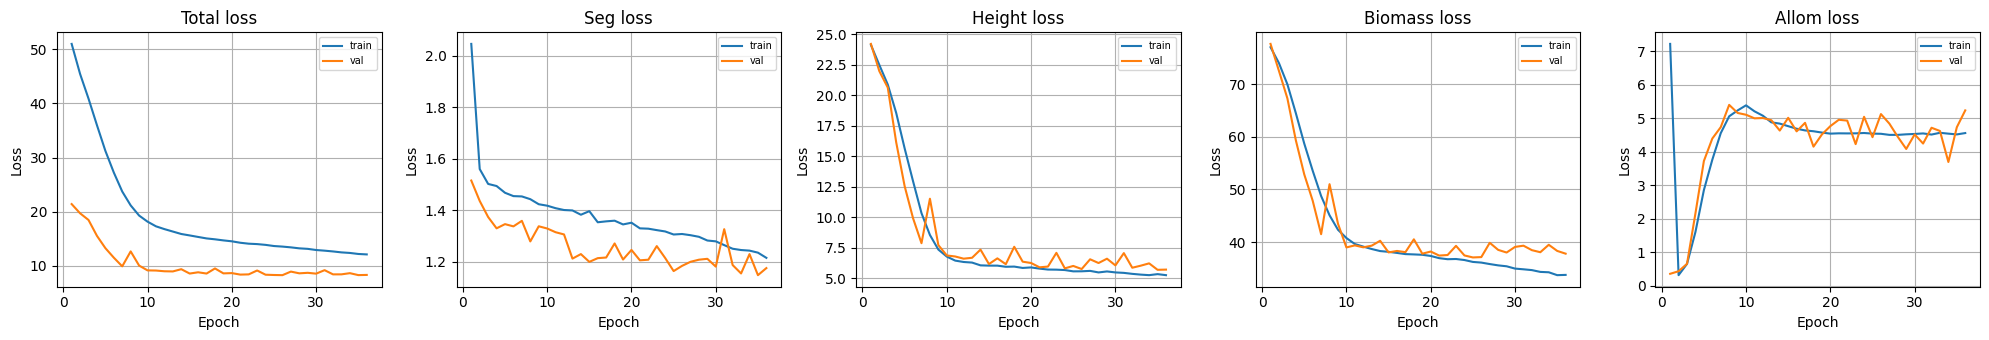

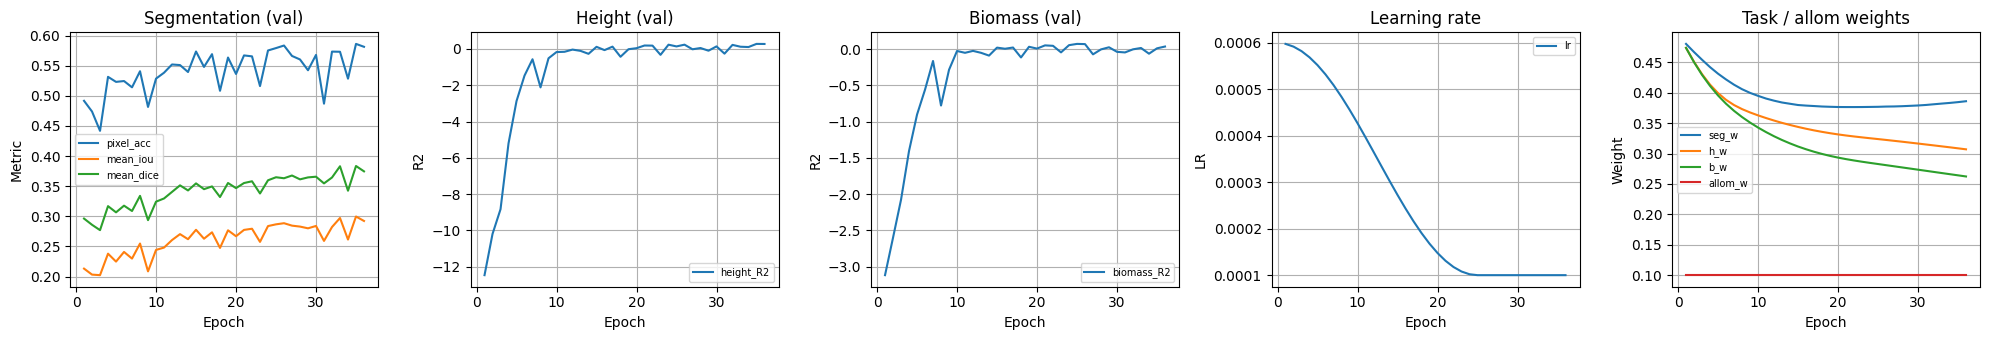

In [142]:
plot_curves(history)

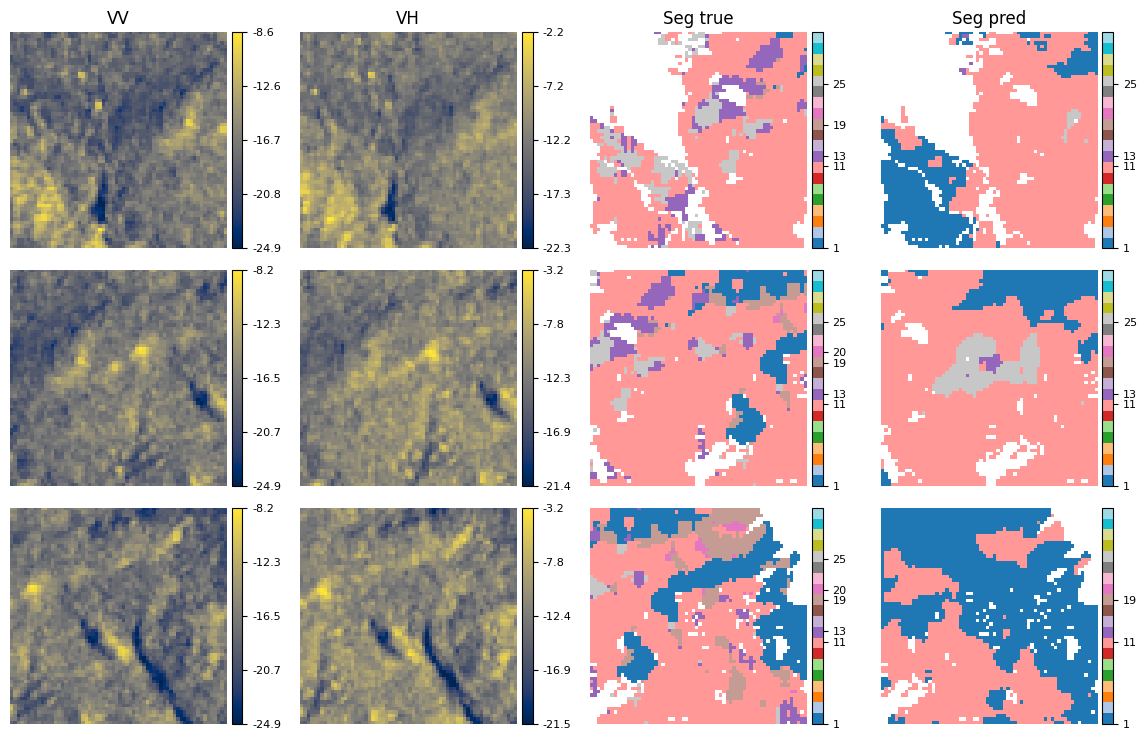

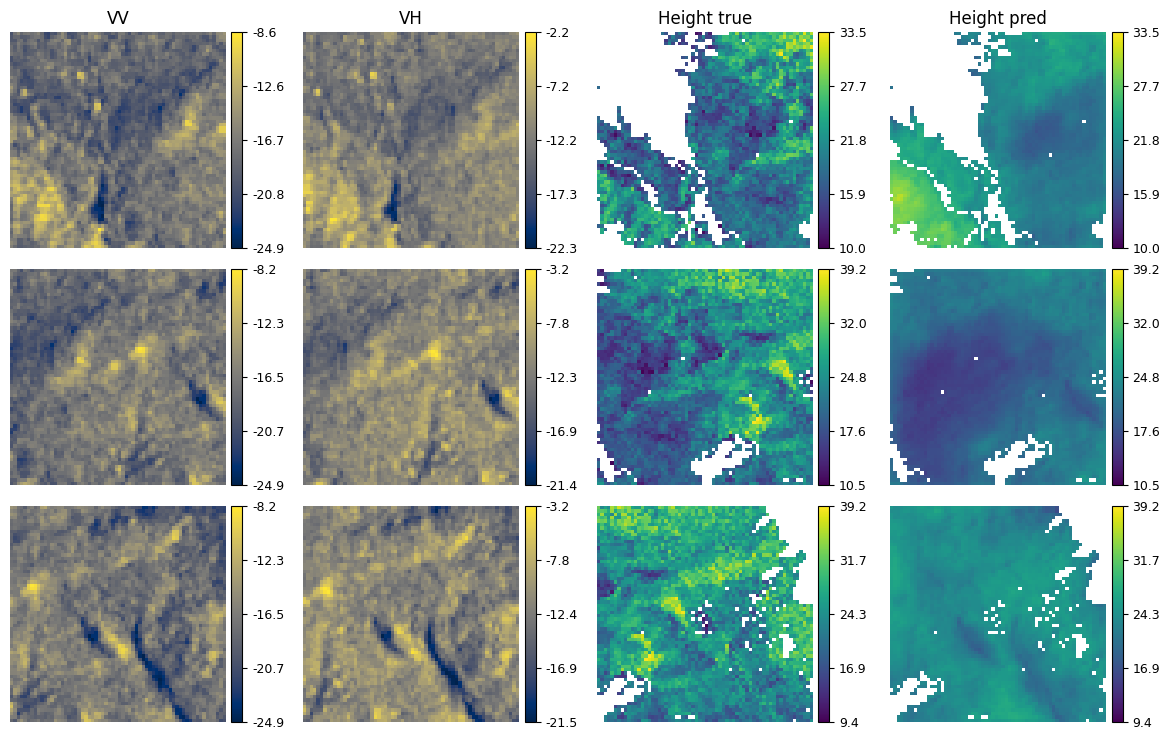

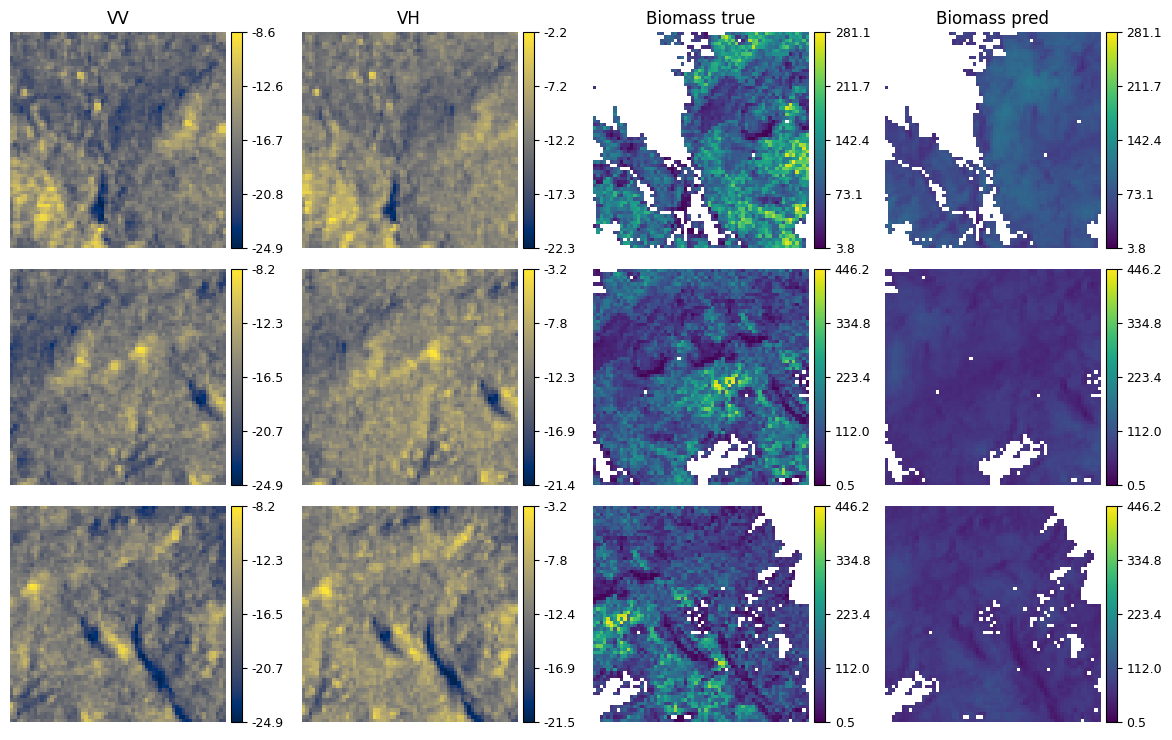

In [143]:
visualize_segmentation_samples(model, test_ds, 33, 3, device)
visualize_regression_samples(model, test_ds, 33, 3, device, target="height")
visualize_regression_samples(model, test_ds, 33, 3, device, target="biomass")

Collect reg pairs: 100%|██████████| 14/14 [00:00<00:00, 59.42it/s]


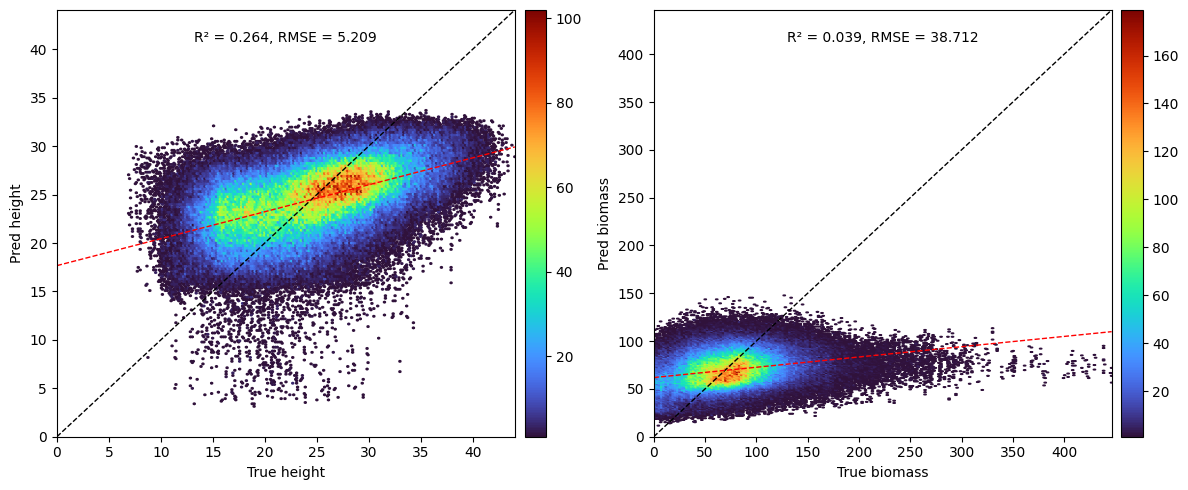

In [144]:
test_true_h, test_pred_h = collect_regression_pairs(
    model,
    loader=test_loader,
    device=device,
    target="height",
)
test_true_b, test_pred_b = collect_regression_pairs(
    model,
    loader=test_loader,
    device=device,
    target="biomass",
)

plot_joint_scatter(test_true_h, test_pred_h, test_true_b, test_pred_b)

Collect reg pairs: 100%|██████████| 91/91 [00:00<00:00, 94.74it/s] 
/tmp/ipython-input-2161705885.py:42: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(y_true, y_pred, 1)


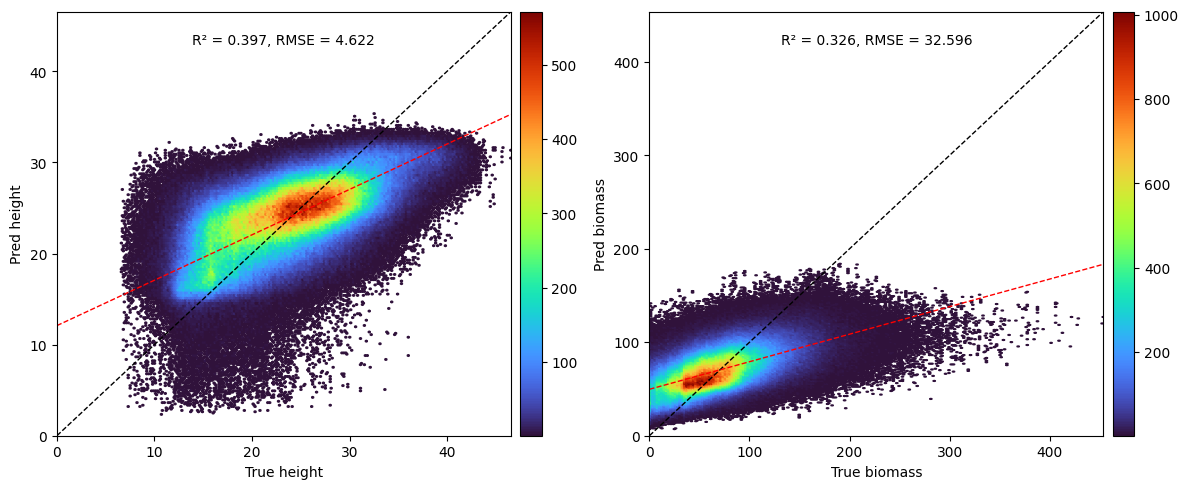

In [145]:
train_true_h, train_pred_h = collect_regression_pairs(model, loader=train_loader, device=device, target="height")
train_true_b, train_pred_b = collect_regression_pairs(model, loader=train_loader, device=device, target="biomass")
plot_joint_scatter(train_true_h, train_pred_h, train_true_b, train_pred_b)

Collect reg pairs: 100%|██████████| 19/19 [00:00<00:00, 64.06it/s]


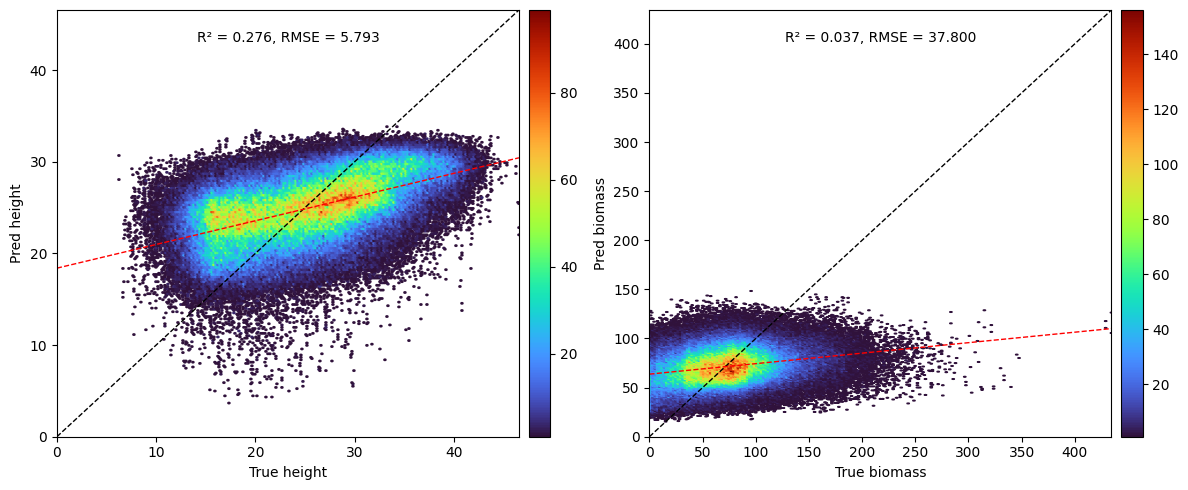

In [146]:
val_true_h, val_pred_h = collect_regression_pairs(model, loader=val_loader, device=device, target="height")
val_true_b, val_pred_b = collect_regression_pairs(model, loader=val_loader, device=device, target="biomass")
plot_joint_scatter(val_true_h, val_pred_h, val_true_b, val_pred_b)